In [9]:
import os
import glob
import numpy as np
import xarray as xr
from scipy.ndimage import rotate

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import matplotlib
matplotlib.rcParams.update({'font.size':15})
import time
import cartopy.crs as ccrs
import cartopy
CMIP6_FOLDER = "/global/cfs/projectdirs/m3522/cmip6/"
SCRATCH="/global/cscratch1/sd/qnicolas/"

import sys
p = os.path.abspath('/global/homes/q/qnicolas/')
if p not in sys.path:
    sys.path.append(p)

from orographicPrecipitation.observationsAndERA5.mountainUtils import *

from scipy.stats import linregress
xr.set_options(display_style='text') 

In [2]:
import dask
dask.config.config["distributed"]["dashboard"]["link"] = "{JUPYTERHUB_SERVICE_PREFIX}proxy/{port}/status"
from dask.distributed import Client
client=Client(memory_limit="35GB")

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36431 instead
  http_address["port"], self.http_server.port


# Functions, data loading

In [2]:
def resample_monthly(ds):
    """performs the same job as resample(time="1M") but keeps missing months out"""
    dsm = ds.resample(time='1M').mean()
    return dsm.dropna('time')

In [3]:
def resample_ndaily(ds,ndays=3):
    """performs the same job as resample(time="[ndays]D") but keeps missing months out"""
    dsm = ds.resample(time='%iD'%ndays).mean()
    return dsm.dropna('time')

In [10]:
Ghats      = MountainRangeCustom("ghats"      ,[64,82,7,24]   ,"Western Ghats"           ,70 ,[6,7,8]  ,[ 75  ,   9  ,  71.5, 20   ,2  ])
Myanmar    = MountainRangeCustom("myanmar"    ,[84,102,7,24]  ,"Myanmar"                 ,60 ,[6,7,8]  ,[ 98  ,  11  ,  90  , 21   ,4  ])
Vietnam    = MountainRangeCustom("vietnam"    ,[100,118,8,25] ,"Annamite range (Vietnam)",240,[10,11]  ,[108  ,  18  , 111  , 13   ,2  ])
Malaysia   = MountainRangeCustom("malaysia"   ,[96,114,-2,15] ,"Malaysia"                ,225,[11,12]  ,[102.5,   8  , 105.5,  3   ,2  ])
Philippines= MountainRangeCustom("philippines",[117,135,5,22] ,"Philippines"             ,225,[11,12]  ,[123.5,  17  , 127  ,  9   ,2  ])
Newbritain = MountainRangeCustom("newbritain" ,[145,163,-17,0],"New Britain"             ,320,[6,7,8]  ,[154  , - 5.5, 150  , -8.5 ,2  ])
Cascades   = MountainRangeCustom("cascades"   ,[222,240,43,60],"British Columbia cascades",45 ,[1,11,12],[235,47,227,54,3])

MRs = (Ghats,Myanmar,Vietnam,Malaysia,Philippines,Newbritain)

Ghats      .angleL = 90
Myanmar    .angleL = 60
Vietnam    .angleL = 250
Malaysia   .angleL = 240
Philippines.angleL = 260
Newbritain .angleL = 275
Cascades.angleL = 45

In [11]:
%%time
ti = time.time()
for MR in MRs:
    print(MR.name)
    MR.set_daily_sfc_var('228_246_100u','VAR_100U')
    MR.set_daily_sfc_var('228_247_100v','VAR_100V')
    MR.set_uperp_sfc()
    MR.vars['VAR_100U_PARA_DAILY'] = crossslopeflow(MR.vars['VAR_100U_DAILY'], MR.vars['VAR_100V_DAILY'],MR.angle-90)
    
    MR.set_daily_imerg()
    MR.set_daily_Blsimple_vars('deep')
    MR.set_daily_Blsimple_vars()
    
    MR.set_daily_sfc_var('128_034_sstk','SST')
    
    MR.vars['Q_DAILY'] = xr.open_dataarray("/global/cscratch1/sd/qnicolas/regionsDataBig/e5.oper.an.pl.128_133_q.ll025sc.2001-2020.{}.{}.nc".format(MR._monthstr,MR.name)).sortby('time')
    MR.vars['T_DAILY'] = xr.open_dataarray("/global/cscratch1/sd/qnicolas/regionsDataBig/e5.oper.an.pl.128_130_t.ll025sc.2001-2020.{}.{}.nc".format(MR._monthstr,MR.name)).sortby('time')
    
    for varname in 'SST','EB','TLDEEP','QLDEEP','EBDEEP','BLDEEPSIMPLE','GPM_PR':
        grid = MR.vars[varname+'_DAILY']
        MR.set_spatialmean(varname,'above',tilted_rect(grid,*MR.box_tilted,reverse=False),box=None)

    for varname in ['VAR_100U_PERP',]:
        grid = MR.vars['VAR_100U_DAILY']
        MR.set_spatialmean(varname,'interval',tilted_rect_distance(grid,*MR.box_tilted[:-1],0,-3),box=None)


ghats
myanmar
vietnam
malaysia
philippines
newbritain
CPU times: user 21.4 s, sys: 36.8 s, total: 58.2 s
Wall time: 1min 6s


In [6]:
%%time
for MR in MRs:
    u = xr.open_dataarray("/global/cscratch1/sd/qnicolas/regionsDataBig/e5.oper.an.pl.128_131_u.ll025sc.2001-2020.{}.{}.nc".format(MR._monthstr,MR.name)).sortby('time')
    v = xr.open_dataarray("/global/cscratch1/sd/qnicolas/regionsDataBig/e5.oper.an.pl.128_132_v.ll025sc.2001-2020.{}.{}.nc".format(MR._monthstr,MR.name)).sortby('time')
    MR.vars['U_DAILY'] = u
    MR.vars['V_DAILY'] = v
    MR.vars['UBL_DAILY'] = u.sel(level=slice(900,1100)).mean('level')
    MR.vars['VBL_DAILY'] = v.sel(level=slice(900,1100)).mean('level')
    #MR.vars['UBL_DAILY'].to_netcdf("/global/cscratch1/sd/qnicolas/regionsDataBig/e5.diagnostic.uBL.2001-2020.{}.{}.nc".format(MR._monthstr,MR.name))
    #MR.vars['VBL_DAILY'].to_netcdf("/global/cscratch1/sd/qnicolas/regionsDataBig/e5.diagnostic.vBL.2001-2020.{}.{}.nc".format(MR._monthstr,MR.name))
    MR.vars['UL_DAILY'] = u.sel(level=slice(600,899)).mean('level')
    MR.vars['VL_DAILY'] = v.sel(level=slice(600,899)).mean('level')
    MR.vars['ULL_DAILY'] = u.sel(level=slice(750,899)).mean('level')
    MR.vars['VLL_DAILY'] = v.sel(level=slice(750,899)).mean('level')

CPU times: user 3.4 s, sys: 7.22 s, total: 10.6 s
Wall time: 1min 50s


In [8]:
Ghats.angle=90
Myanmar.angle=50
Malaysia.angle=245
Philippines.angle=260
for MR in MRs:
    MR.vars['UBL_PERP_DAILY'] = crossslopeflow(MR.vars['UBL_DAILY'],MR.vars['VBL_DAILY'],MR.angle)
    MR.vars['UBL_PARA_DAILY'] = crossslopeflow(MR.vars['UBL_DAILY'],MR.vars['VBL_DAILY'],MR.angle-90) 
    MR.set_spatialmean('UBL_PERP','interval',tilted_rect_distance(MR.vars['VAR_100U_DAILY'],*MR.box_tilted[:-1],0,-3),box=None)

In [15]:
%%time
Newbritain.set_3dvar('PHI',"128_129_z")
sample_geopotential = Newbritain.vars['PHI'].mean(['latitude','longitude'])/9.81
dzdp = sample_geopotential.differentiate('level')

for MR in MRs[:1]:
    MR.vars['DQDZ_DAILY'] = MR.vars['Q_DAILY'].differentiate('level') * 2.5e6/1004. /dzdp
    MR.set_spatialmean('DQDZ','above',tilted_rect(MR.vars['DQDZ_DAILY'],*MR.box_tilted,reverse=False),box=None)
    MR.vars['DSDZ_DAILY'] = MR.vars['T_DAILY'].differentiate('level') / dzdp + 9.81/1004.

CPU times: user 14.1 s, sys: 21.3 s, total: 35.4 s
Wall time: 36 s


In [16]:

from orographicPrecipitation.precip_model_functions import humidsat,qsat
def compute_BLsemisimple(eb,eL,eLstar):
    kappaL=3
    g=9.81
    wB = 0.52
    wL = 1-wB
    Pib = 0.985
    PiL = 0.91
    BLsimple = g/eLstar*PiL*(wB*eb/Pib+(wL*eL-eLstar)/PiL)
    return BLsimple

for MR in MRs[:1]:
    MR.vars['TLSEMI_DAILY'] = MR.vars['T_DAILY'].sel(level=slice(600,899)).mean('level')
    MR.vars['QLSEMI_DAILY'] = MR.vars['Q_DAILY'].sel(level=slice(600,899)).mean('level')
    qs=qsat(MR.vars['T_DAILY'].sel(level=slice(600,849)),MR.vars['T_DAILY'].sel(level=slice(600,899)).level).mean('level')
    eL = 2.5e6/1004* MR.vars['QLSEMI_DAILY']+MR.vars['TLSEMI_DAILY']
    eLstar = 2.5e6/1004*qs+MR.vars['TLSEMI_DAILY']
    #MR.vars['BLSEMISIMPLE_DAILY'] = compute_BLsemisimple(MR.vars['EB_DAILY'],eL,eLstar)
    #for varname in ['BLSEMISIMPLE','TLSEMI','QLSEMI']:
    #    grid = MR.vars[varname+'_DAILY']
    #    MR.set_spatialmean(varname,'above',tilted_rect(grid,*MR.box_tilted,reverse=False),box=None)
        
    filepaths = [MR.path+"e5.diagnostic.{}{}.2001-2020.{}.{}.nc".format(varcode,"semi",MR._monthstr,MR.name) for varcode in ("eL","eLstar","tL","qL")]
    for fp,var in zip(filepaths,(eL,)):#eLstar,MR.vars['TLSEMI_DAILY'],MR.vars['QLSEMI_DAILY'])):
        var.to_netcdf(fp)

In [24]:
%%time
for MR in MRs:
    pv = xr.open_dataarray("/global/cscratch1/sd/qnicolas/regionsDataBig/e5.oper.an.pl.128_060_pv.ll025sc.2001-2020.{}.{}.nc".format(MR._monthstr,MR.name)).sortby('time')
    MR.vars['PVBL_DAILY'] = pv.sel(level=slice(900,1100)).mean('level')
    MR.vars['PVLL_DAILY'] = pv.sel(level=slice(750,899)).mean('level')

CPU times: user 16.1 s, sys: 10.9 s, total: 27 s
Wall time: 1min 34s


In [131]:
%%time
for MR in (Ghats, Philippines):
    w = xr.open_dataarray("/global/cscratch1/sd/qnicolas/regionsDataBig/e5.oper.an.pl.128_135_w.ll025sc.2001-2020.{}.{}.nc".format(MR._monthstr,MR.name)).sortby('time')
    MR.vars['WL_DAILY'] = w.sel(level=slice(600,899)).mean('level')
    MR.set_spatialmean('WL','above',tilted_rect(MR.vars['WL_DAILY'],*MR.box_tilted,reverse=False),box=None)
    

CPU times: user 1.83 s, sys: 1.68 s, total: 3.51 s
Wall time: 2.8 s


In [11]:
def get_bins(var,nbins):
    var_sorted = sorted(np.array(var).reshape(-1))
    quantiles=np.linspace(0.,len(var)-1,nbins+1)
    bins = [var_sorted[int(i)]  for i in quantiles]
    bin_centers = [np.mean(var_sorted[int(quantiles[i]):int(quantiles[i+1])]) for i in range(len(quantiles)-1)]
    return np.array(bins)#,np.array(bin_centers)

def select_bootstrap_sample(distribution):
    n=len(distribution)
    return distribution[np.random.randint(0,n,size=n)]
def bootstrap_CI_mean(data,CI_level,nsamples=100):
    """Compute a confidence interval for the mean of a et of data at the level CI_level (0<CI_level<100), using nsamples bootstrap samples"""
    means = np.zeros(nsamples)
    for i in range(nsamples):
        means[i]=select_bootstrap_sample(data).mean()
    return [np.percentile(means,50-CI_level/2),np.percentile(means,50+CI_level/2)]

def get_binned(a,b,bins,itq=False,bootstrap=False):
    idx_bin_inf = max(0,np.argmax(bins>float(a.min()))-1)
    idx_bin_sup = np.argmin(bins<float(a.max()))
    if idx_bin_sup==0 or idx_bin_sup==len(bins)-1:
        bins=bins[idx_bin_inf:]
    else:
        bins=bins[idx_bin_inf:idx_bin_sup+1]
    bin_centers=(bins[1:]+bins[:-1])/2
    digitized = np.digitize(np.array(a), bins)
    bin_means = np.array([np.array(b)[digitized == i].mean() for i in range(1, len(bins))])
    if itq:
        bin_median = np.array([np.median(np.array(b)[digitized == i]) for i in range(1, len(bins))])
        try:
            bin_q1 = np.array([np.quantile(np.array(b)[digitized == i],0.25) for i in range(1, len(bins))])
            bin_q2 = np.array([np.quantile(np.array(b)[digitized == i],0.75) for i in range(1, len(bins))])
        except IndexError:
            bin_q1 = bin_median
            bin_q2 = bin_median
        return bin_centers,bin_means,bin_median,bin_q1,bin_q2
    elif bootstrap :
        cinf_csup =  np.array([bootstrap_CI_mean(np.array(b)[digitized == i],95) for i in range(1, len(bins))])
        return bin_centers,bin_means,cinf_csup[:,0],cinf_csup[:,1]
    else:
        return bin_centers,bin_means

def get_count(a,bins):
    idx_bin_inf = max(0,np.argmax(bins>float(a.min()))-1)
    idx_bin_sup = np.argmin(bins<float(a.max()))
    if idx_bin_sup==0 or idx_bin_sup==len(bins)-1:
        bins=bins[idx_bin_inf:]
    else:
        bins=bins[idx_bin_inf:idx_bin_sup+1]
    bin_centers=(bins[1:]+bins[:-1])/2
    count = np.histogram(a,bins)[0]
    return bin_centers,count

In [12]:
from scipy.optimize import curve_fit
def fit(pred,dep,model='linear'):
    predrange = np.linspace(np.min(pred),np.max(pred),41)
    if model=='linear':
        func = lambda x,a,b : a*x+b
    elif model=='exponential':
        func = lambda x,a,b : np.exp(a*x+b)
    elif model=='softplus':
        func = lambda x,a,b : np.log(1+np.exp(a*x+b))
    popt,_ = curve_fit(func,pred,dep)
    fitrange = func(predrange,*popt)
    residual = dep - func(pred,*popt)
    rss = np.sum(residual**2)
    tss = len(dep)*np.var(dep)
    rsq = 1-rss/tss
    return predrange,fitrange,rsq

def fit_coefs(pred,dep,model='linear'):
    predrange = np.linspace(np.min(pred),np.max(pred),41)
    if model=='linear':
        func = lambda x,a,b : a*x+b
    elif model=='exponential':
        func = lambda x,a,b : np.exp(a*x+b)
    elif model=='softplus':
        func = lambda x,a,b : np.log(1+np.exp(a*x+b))
    popt,_ = curve_fit(func,pred,dep)
    fitrange = func(predrange,*popt)
    residual = dep - func(pred,*popt)
    rss = np.sum(residual**2)
    tss = len(dep)*np.var(dep)
    rsq = 1-rss/tss
    return predrange,fitrange,rsq,popt

def rsq_fixedcoefs(pred,dep,popt,model='linear'):
    if model=='linear':
        func = lambda x,a,b : a*x+b
    elif model=='exponential':
        func = lambda x,a,b : np.exp(a*x+b)
    elif model=='softplus':
        func = lambda x,a,b : np.log(1+np.exp(a*x+b))
    residual = dep - func(pred,*popt)
    rss = np.sum(residual**2)
    tss = len(dep)*np.var(dep)
    rsq = 1-rss/tss
    return rsq

BL_exp_fit = lambda bl : np.exp(18*bl+4.8)

In [13]:
from scipy import special
def linregress_xr_2(x,y,dim='time'):
    nt = len(x[dim])
    assert nt==len(y[dim])
    ssxm = nt*x.var(dim=dim)
    ssym = nt*y.var(dim=dim)
    ssxym = nt*xr.cov(x,y,dim=dim)       
    r = np.maximum(np.minimum(ssxym / np.sqrt(ssxm * ssym),1.),-1)
    slope = ssxym / ssxm
    
    df = nt - 2  # Number of degrees of freedom
    TINY = 1.0e-20
    t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
    
    pval = special.stdtr(df, -np.abs(t))*2 * x.isel({dim:0})**0
    
    return xr.merge([slope.rename('slope'),(r**2).rename('rsquared'),pval.rename('pvalue')])

def fdr(pvalues,alpha):
    sortidx = np.argsort(pvalues)
    psorted = pvalues[sortidx]
    psorted[np.isnan(psorted)]=1
    nval = len(pvalues)
    ifdr = np.argmax((psorted < alpha*np.arange(1,nval+1)/nval)[::-1])
    if ifdr == 0 and psorted[-1]>= alpha:
        ifdr=nval-1
    ifdr = nval - ifdr - 1
    return sortidx[:ifdr]

def fdr_xr_2d(pvalues,alpha):
    pvalues=np.array(pvalues)
    assert len(pvalues.shape)==2
    ntot = pvalues.shape[0]*pvalues.shape[1]
    idxs_1d = fdr(pvalues.reshape(-1),alpha)
    flags = np.zeros(ntot)
    flags[idxs_1d] = 1
    return flags.reshape(pvalues.shape)*pvalues**0

In [101]:
def add_wind(ax,u,v,color='k',width=0.001,scale=600,ref=100,app='/(unit BL)',pos=0.87):
    ax.coastlines()
    X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
    Y = v.longitude.expand_dims({"latitude":u.latitude})
    n=5
    m=5
    q=ax.quiver(np.array(Y)[::n,::m],np.array(X)[::n,::m], np.array(u)[::n,::m], np.array(v)[::n,::m], transform=ccrs.PlateCarree(),color=color,width=width,scale=scale)
    ax.quiverkey(q, pos, 1.03, ref, r'%.1f m s$^{-1}$%s'%(ref,app), labelpos='E', coordinates='axes',color='k')

In [14]:
alpha = 20.6/3600*2.5e6
dBLdqL = 1/(11.3*3600)*1004*8000/alpha
dBLdTL = -1/(2.7*3600)*1004*8000/alpha
dBLdeb = 1/(11.5*3600)*1004*8000/alpha

# Daily scatterplots

CPU times: user 3.16 s, sys: 337 ms, total: 3.5 s
Wall time: 3.28 s


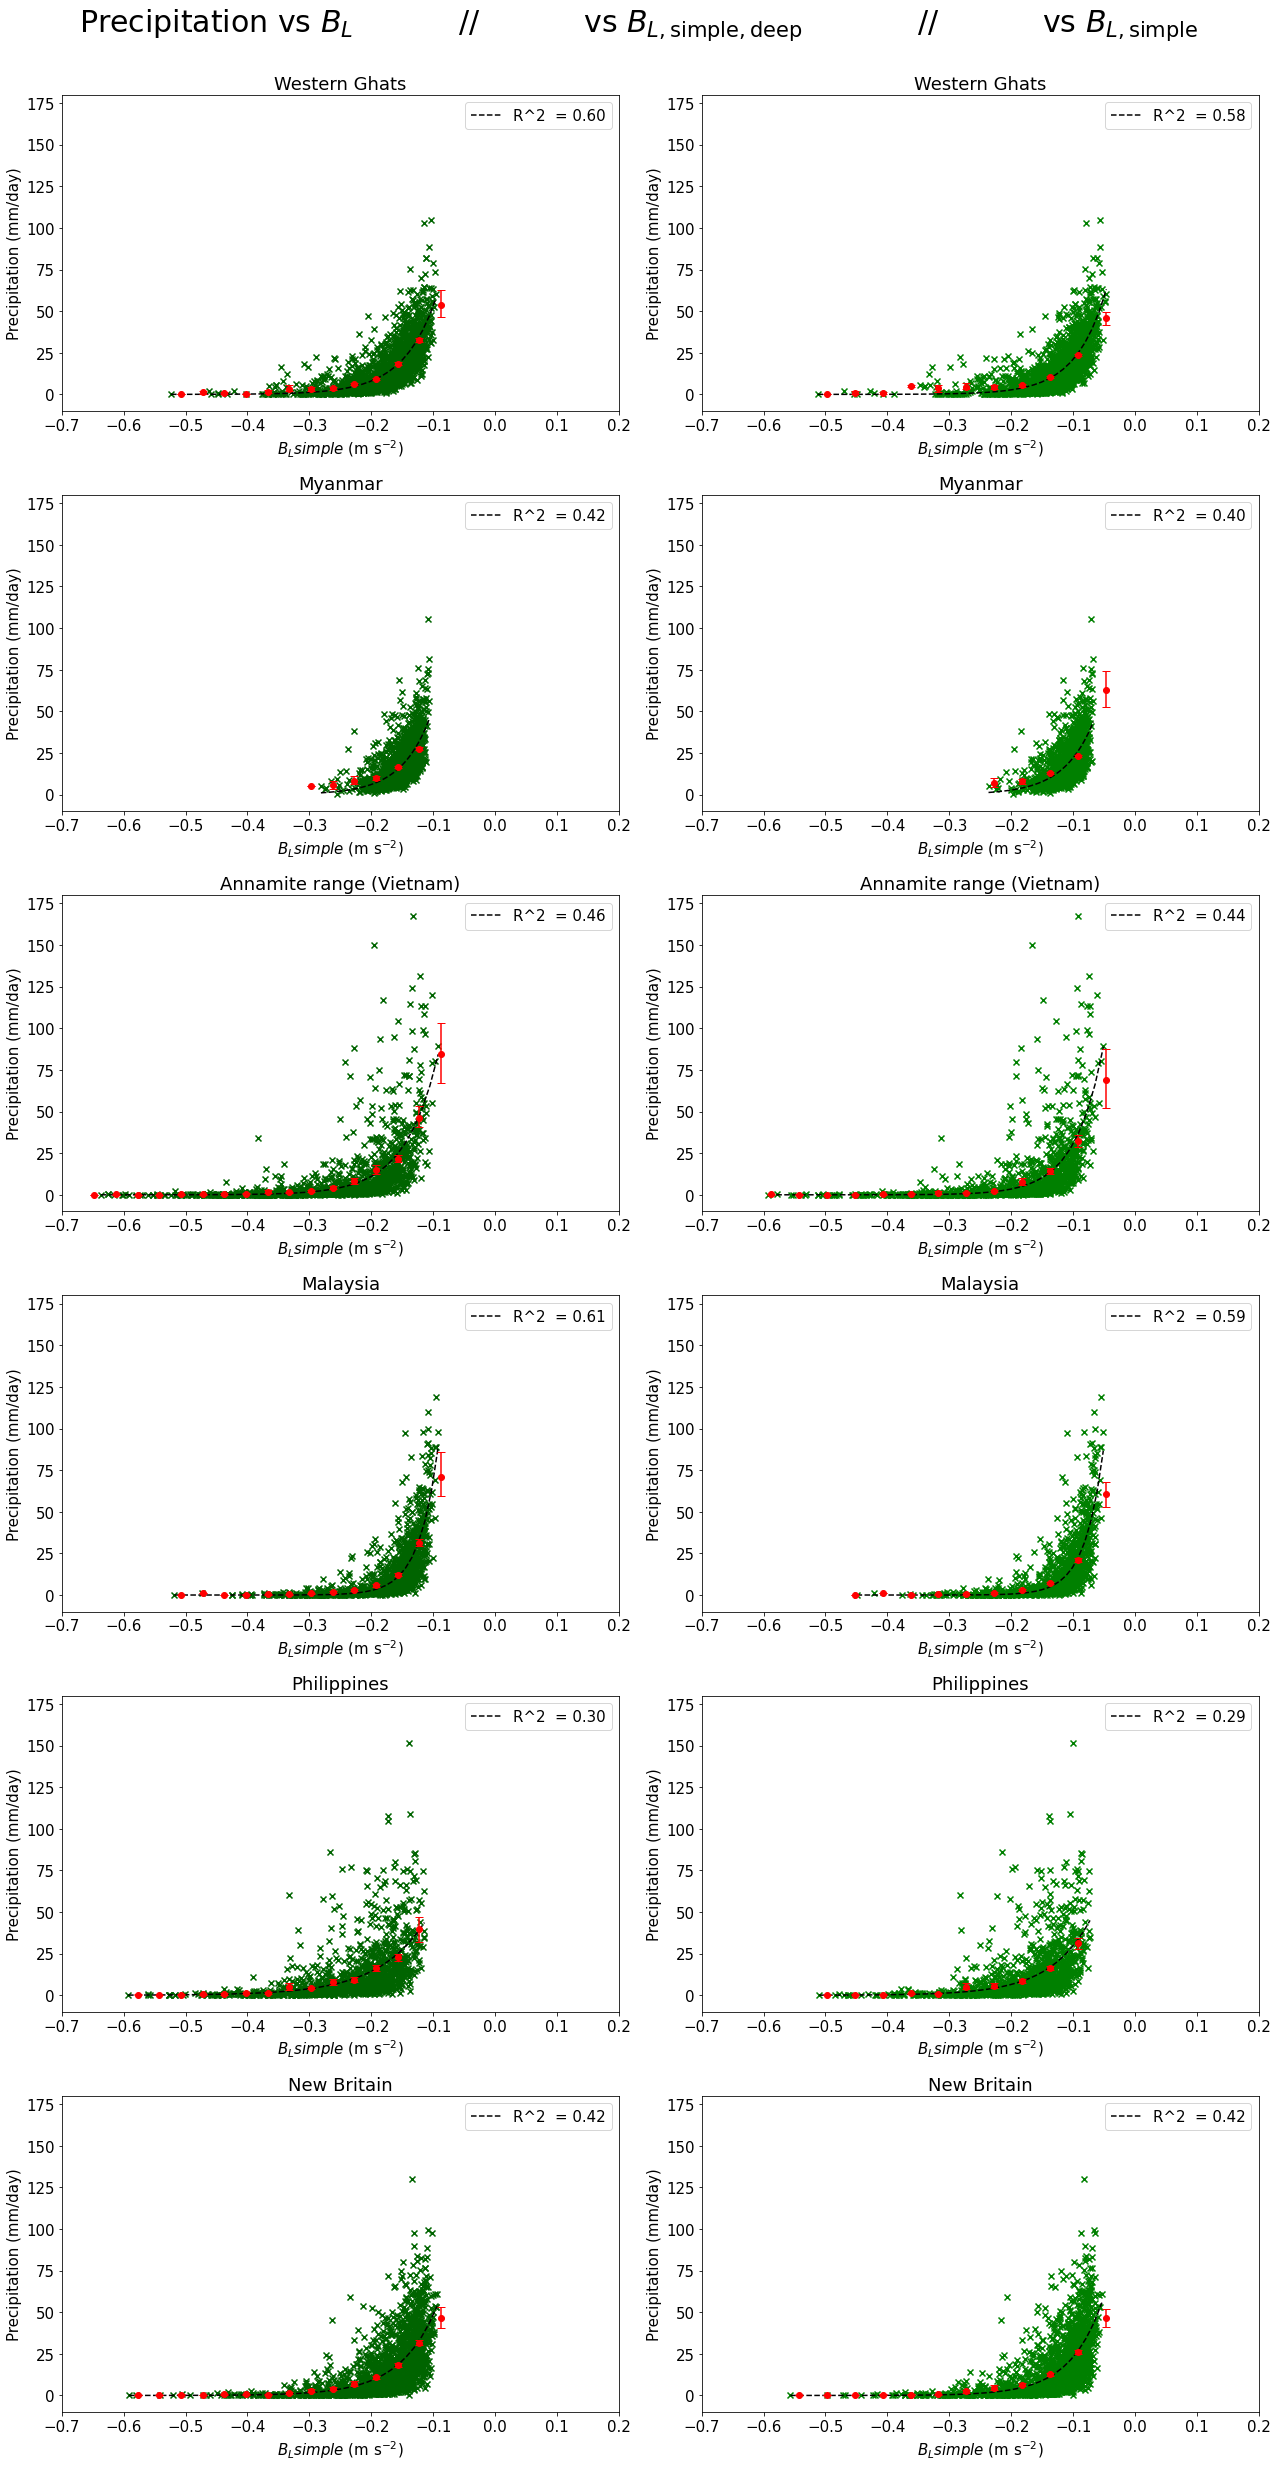

In [34]:
%%time
fig,axs = plt.subplots(6,2,figsize=(18,35))
for j,MR in enumerate(MRs):
    pr = MR.vars['GPM_PR_ABOVE_DAILY']
    Blsimplesemi = MR.vars['BLSEMISIMPLE_ABOVE_DAILY']
    Blsimpledeep = MR.vars['BLDEEPSIMPLE_ABOVE_DAILY']
    
    for i,(pred,c,model,bins) in enumerate(zip((Blsimpledeep,Blsimplesemi),('darkgreen','g'),('exponential','exponential'),(np.linspace(-0.7,0,21),np.linspace(-0.7,0.2,21)))):
        axs[j,i].scatter(pred,pr,marker='x',color=c)
        x,y,rsq = fit(pred,pr,model)
        axs[j,i].plot(x,y,color='k',linestyle='--',label='R^2  = %.2f'%rsq)
        centers,means,q02,q98 = get_binned(pred,pr,bins,bootstrap=True)
        #axs[j,i].plot(centers,means,'or')
        axs[j,i].errorbar(centers,means,yerr=[means-q02,q98-means],fmt='or',ecolor='r',capsize=4)
        
        axs[j,i].set_ylabel("Precipitation (mm/day)")
        axs[j,i].set_title(MR.Lname)
        axs[j,i].legend()
        axs[j,i].set_ylim(-10,180)
    axs[j,0].set_xlabel(r"$B_Lsimple$ (m s$^{-2}$)")
    axs[j,1].set_xlabel(r"$B_Lsimple$ (m s$^{-2}$)")
    axs[j,0].set_xlim(-0.7,0.2)
    axs[j,1].set_xlim(-0.7,0.2)

       
fig.suptitle(r"Precipitation vs $B_L$           //           vs $B_{L,\mathrm{simple,deep}}$            //           vs $B_{L,\mathrm{simple}}$",fontsize=30)
fig.tight_layout(rect=[0, 0, 1, 0.98])

## Share of BL variations

In [29]:
# Evaluating slopes theoretically
alpha = 20.6/3600*2.5e6
dBLdqL = 1/(11.3*3600)*1004*8000/alpha
dBLdTL = -1/(2.7*3600)*1004*8000/alpha
dBLdeb = 1/(11.5*3600)*1004*8000/alpha

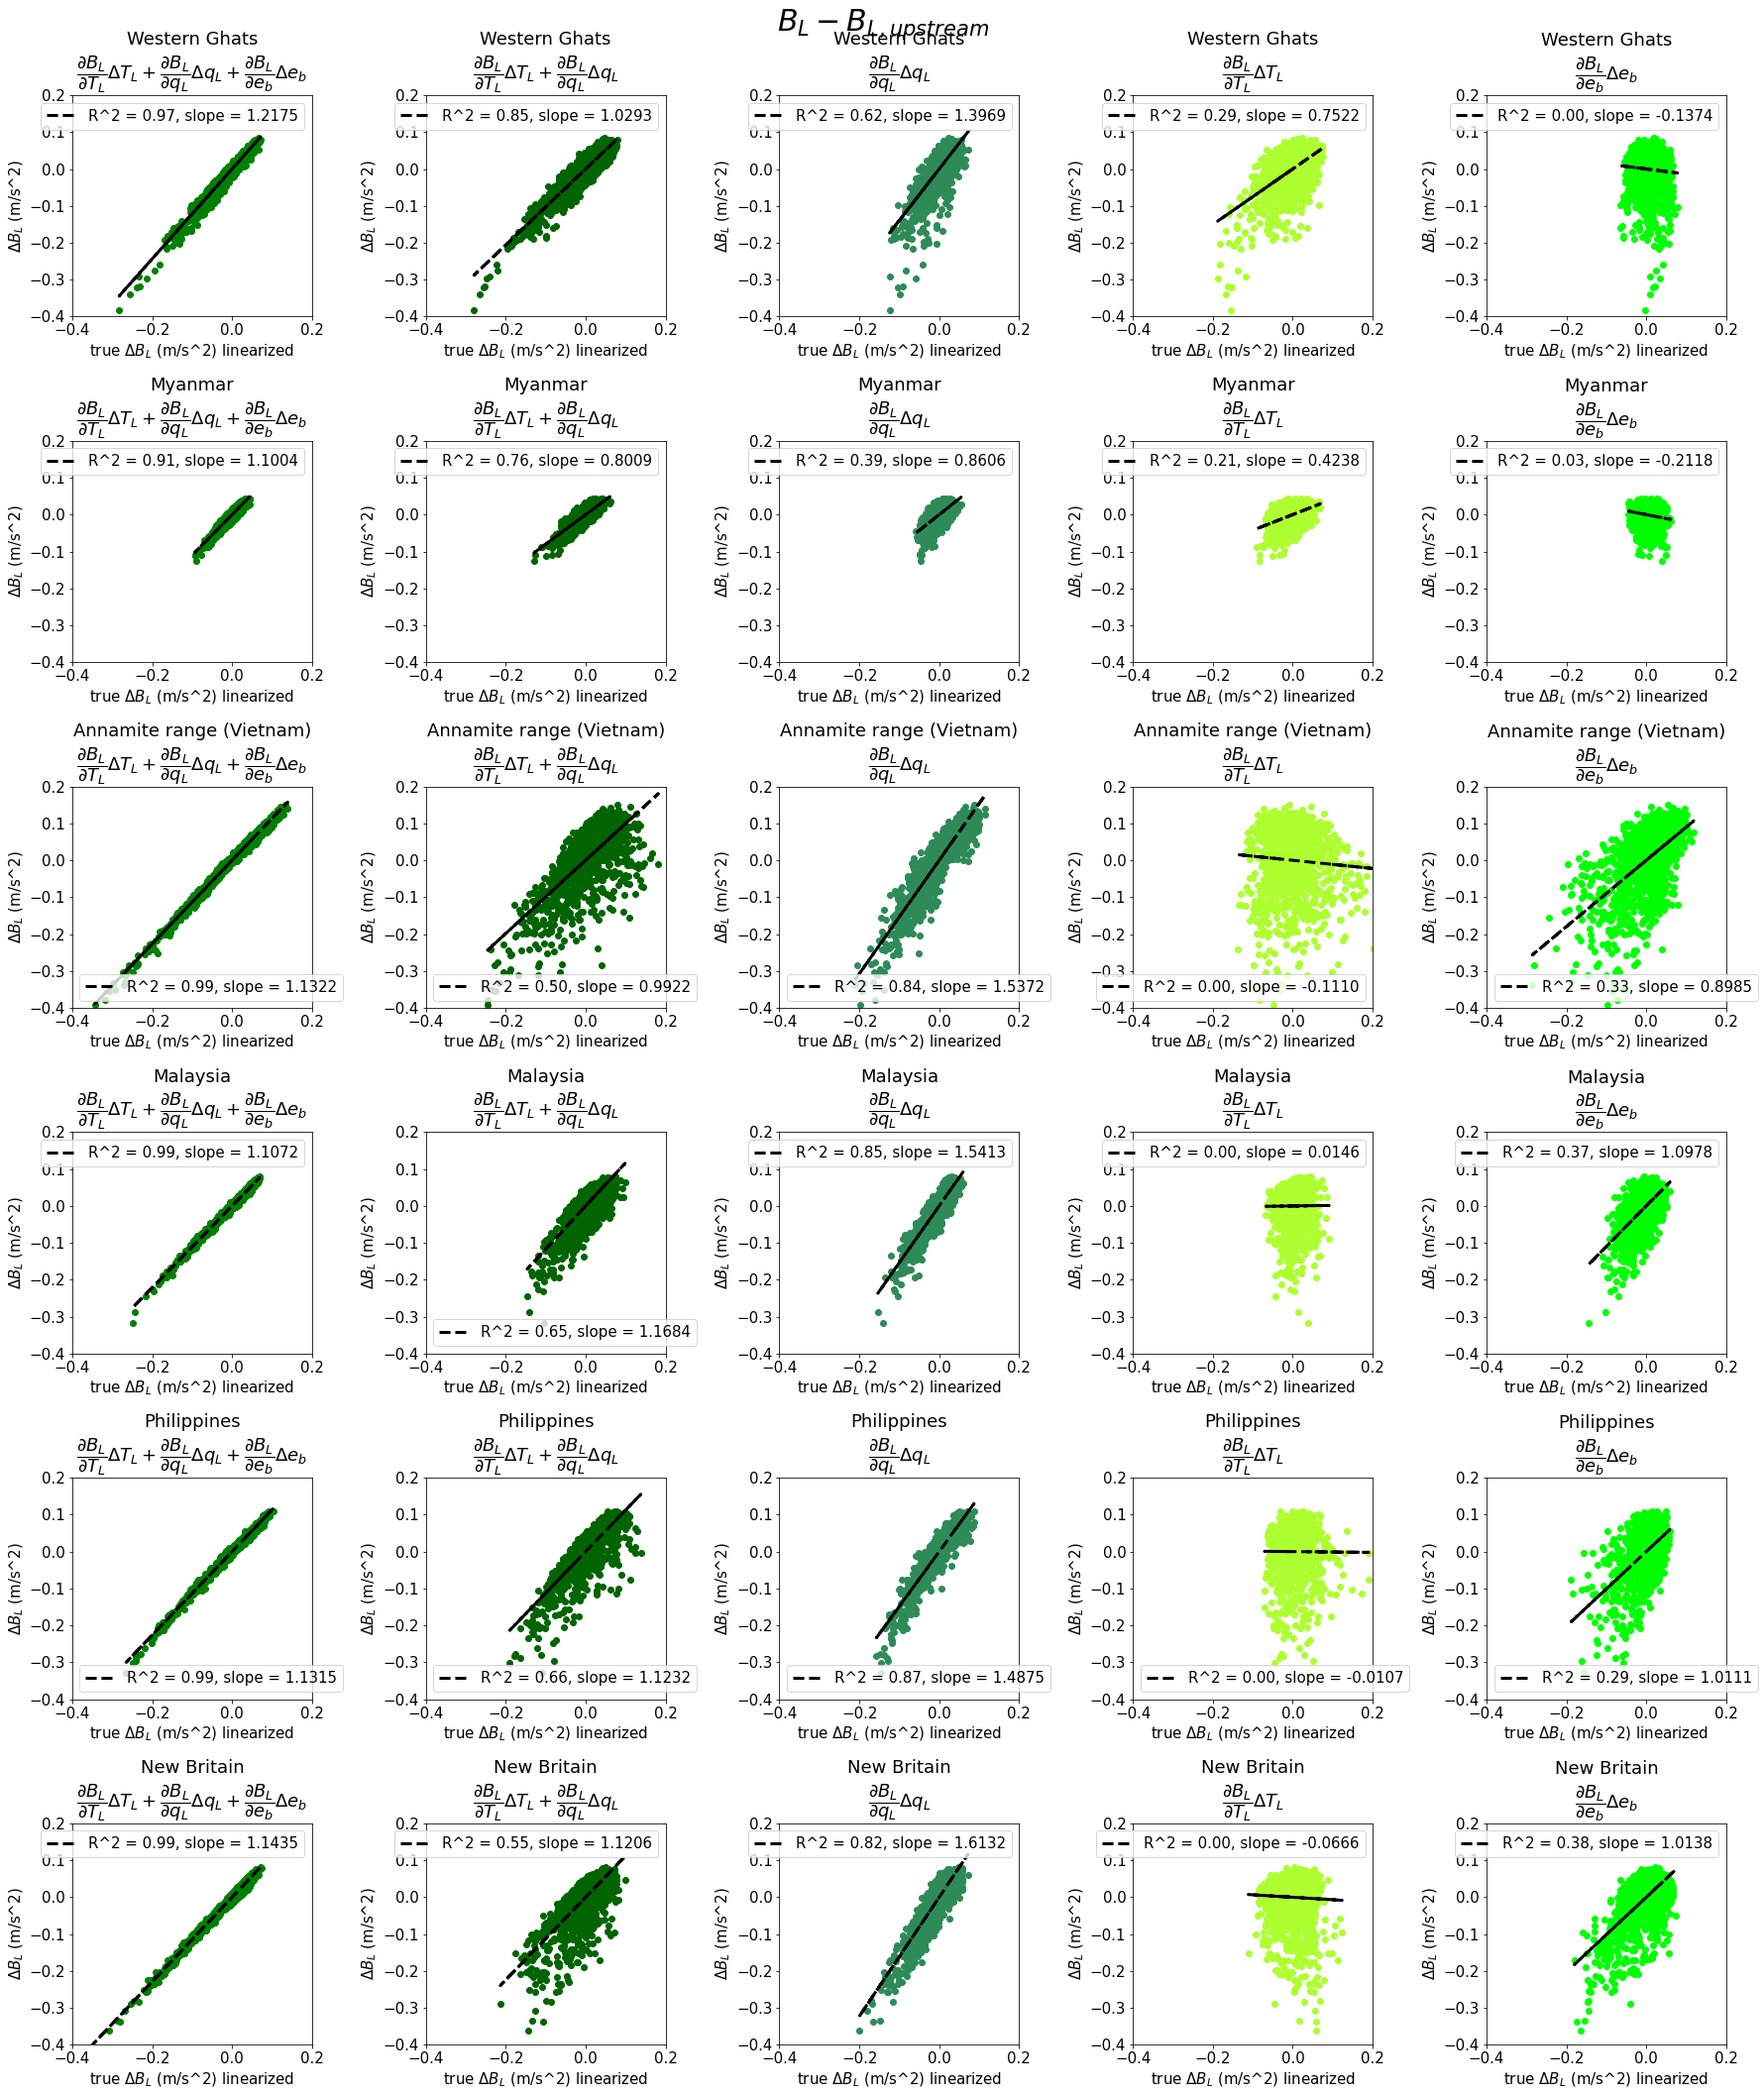

In [86]:
fig,axss = plt.subplots(6,5,figsize=(25,30))
for i,MR in enumerate(MRs):
    axs = axss[i]
    Bl_above = MR.vars['BLSEMISIMPLE_ABOVE_DAILY']
    Bl_rce = MR.vars['BLSEMISIMPLE_ABOVE_DAILY'].mean("time")
    
    predqL = dBLdqL*(MR.vars['QLSEMI_ABOVE_DAILY']-MR.vars['QLSEMI_ABOVE_DAILY'].mean('time'))*2.5e6/1004. 
    predTL = dBLdTL*(MR.vars['TLSEMI_ABOVE_DAILY']-MR.vars['TLSEMI_ABOVE_DAILY'].mean('time'))
    predeb = dBLdeb*(MR.vars['EB_ABOVE_DAILY']-MR.vars['EB_ABOVE_DAILY'].mean('time'))
    
    for j,(pred,c) in enumerate(zip((predqL+predTL+predeb,predqL+predTL,predqL,predTL,predeb),('g','darkgreen','seagreen','greenyellow','lime'))):
        reg = linregress(pred,Bl_above-Bl_rce)
        axs[j].scatter(pred,Bl_above-Bl_rce,color=c)
        axs[j].plot(pred,reg.intercept+reg.slope*pred,color='k',linewidth=3,linestyle='--',label = 'R^2 = %.2f, slope = %.4f'%(reg.rvalue**2,reg.slope))
        axs[j].set_xlabel("true $\Delta B_L$ (m/s^2) linearized")
        axs[j].set_ylabel(r"$\Delta B_L$ (m/s^2)")
        axs[j].legend()
        axs[j].set_xlim(-0.4,0.2)
        axs[j].set_ylim(-0.4,0.2)
    axs[0].set_title(MR.Lname + "\n" + "$\dfrac{\partial B_L}{\partial T_L}\Delta T_L+\dfrac{\partial B_L}{\partial q_L}\Delta q_L+\dfrac{\partial B_L}{\partial e_b}\Delta e_b$")
    axs[1].set_title(MR.Lname + "\n" + "$\dfrac{\partial B_L}{\partial T_L}\Delta T_L+\dfrac{\partial B_L}{\partial q_L}\Delta q_L$")
    axs[2].set_title(MR.Lname + "\n" + "$\dfrac{\partial B_L}{\partial q_L}\Delta q_L$")
    axs[3].set_title(MR.Lname + "\n" + "$\dfrac{\partial B_L}{\partial T_L}\Delta T_L$")
    axs[4].set_title(MR.Lname + "\n" + "$\dfrac{\partial B_L}{\partial e_b}\Delta e_b$")
    
fig.suptitle(r"$B_L-B_{L,upstream}$",fontsize=30)
fig.tight_layout()

# Regressing $T_L'$

In [68]:
Ghats.box_wind = [68,71,16,18]
Myanmar.box_wind=[88,91,16,19]
Vietnam.box_wind=[111,114,14,17]
Malaysia.box_wind=[105,107,4,6]
Philippines.box_wind = [125,127,13,15]
Newbritain.box_wind=[151,153,-9,-7]

def plot_box(ax,box,c='b'):
    ax.add_patch(mpatches.Rectangle(xy=[box[0], box[2]], width=box[1]-box[0], height=box[3]-box[2],
                                   edgecolor=c,
                                   fill = False,
                                   lw=1.5,
                                   linestyle='--',
                                   transform=ccrs.PlateCarree()))
    


/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py

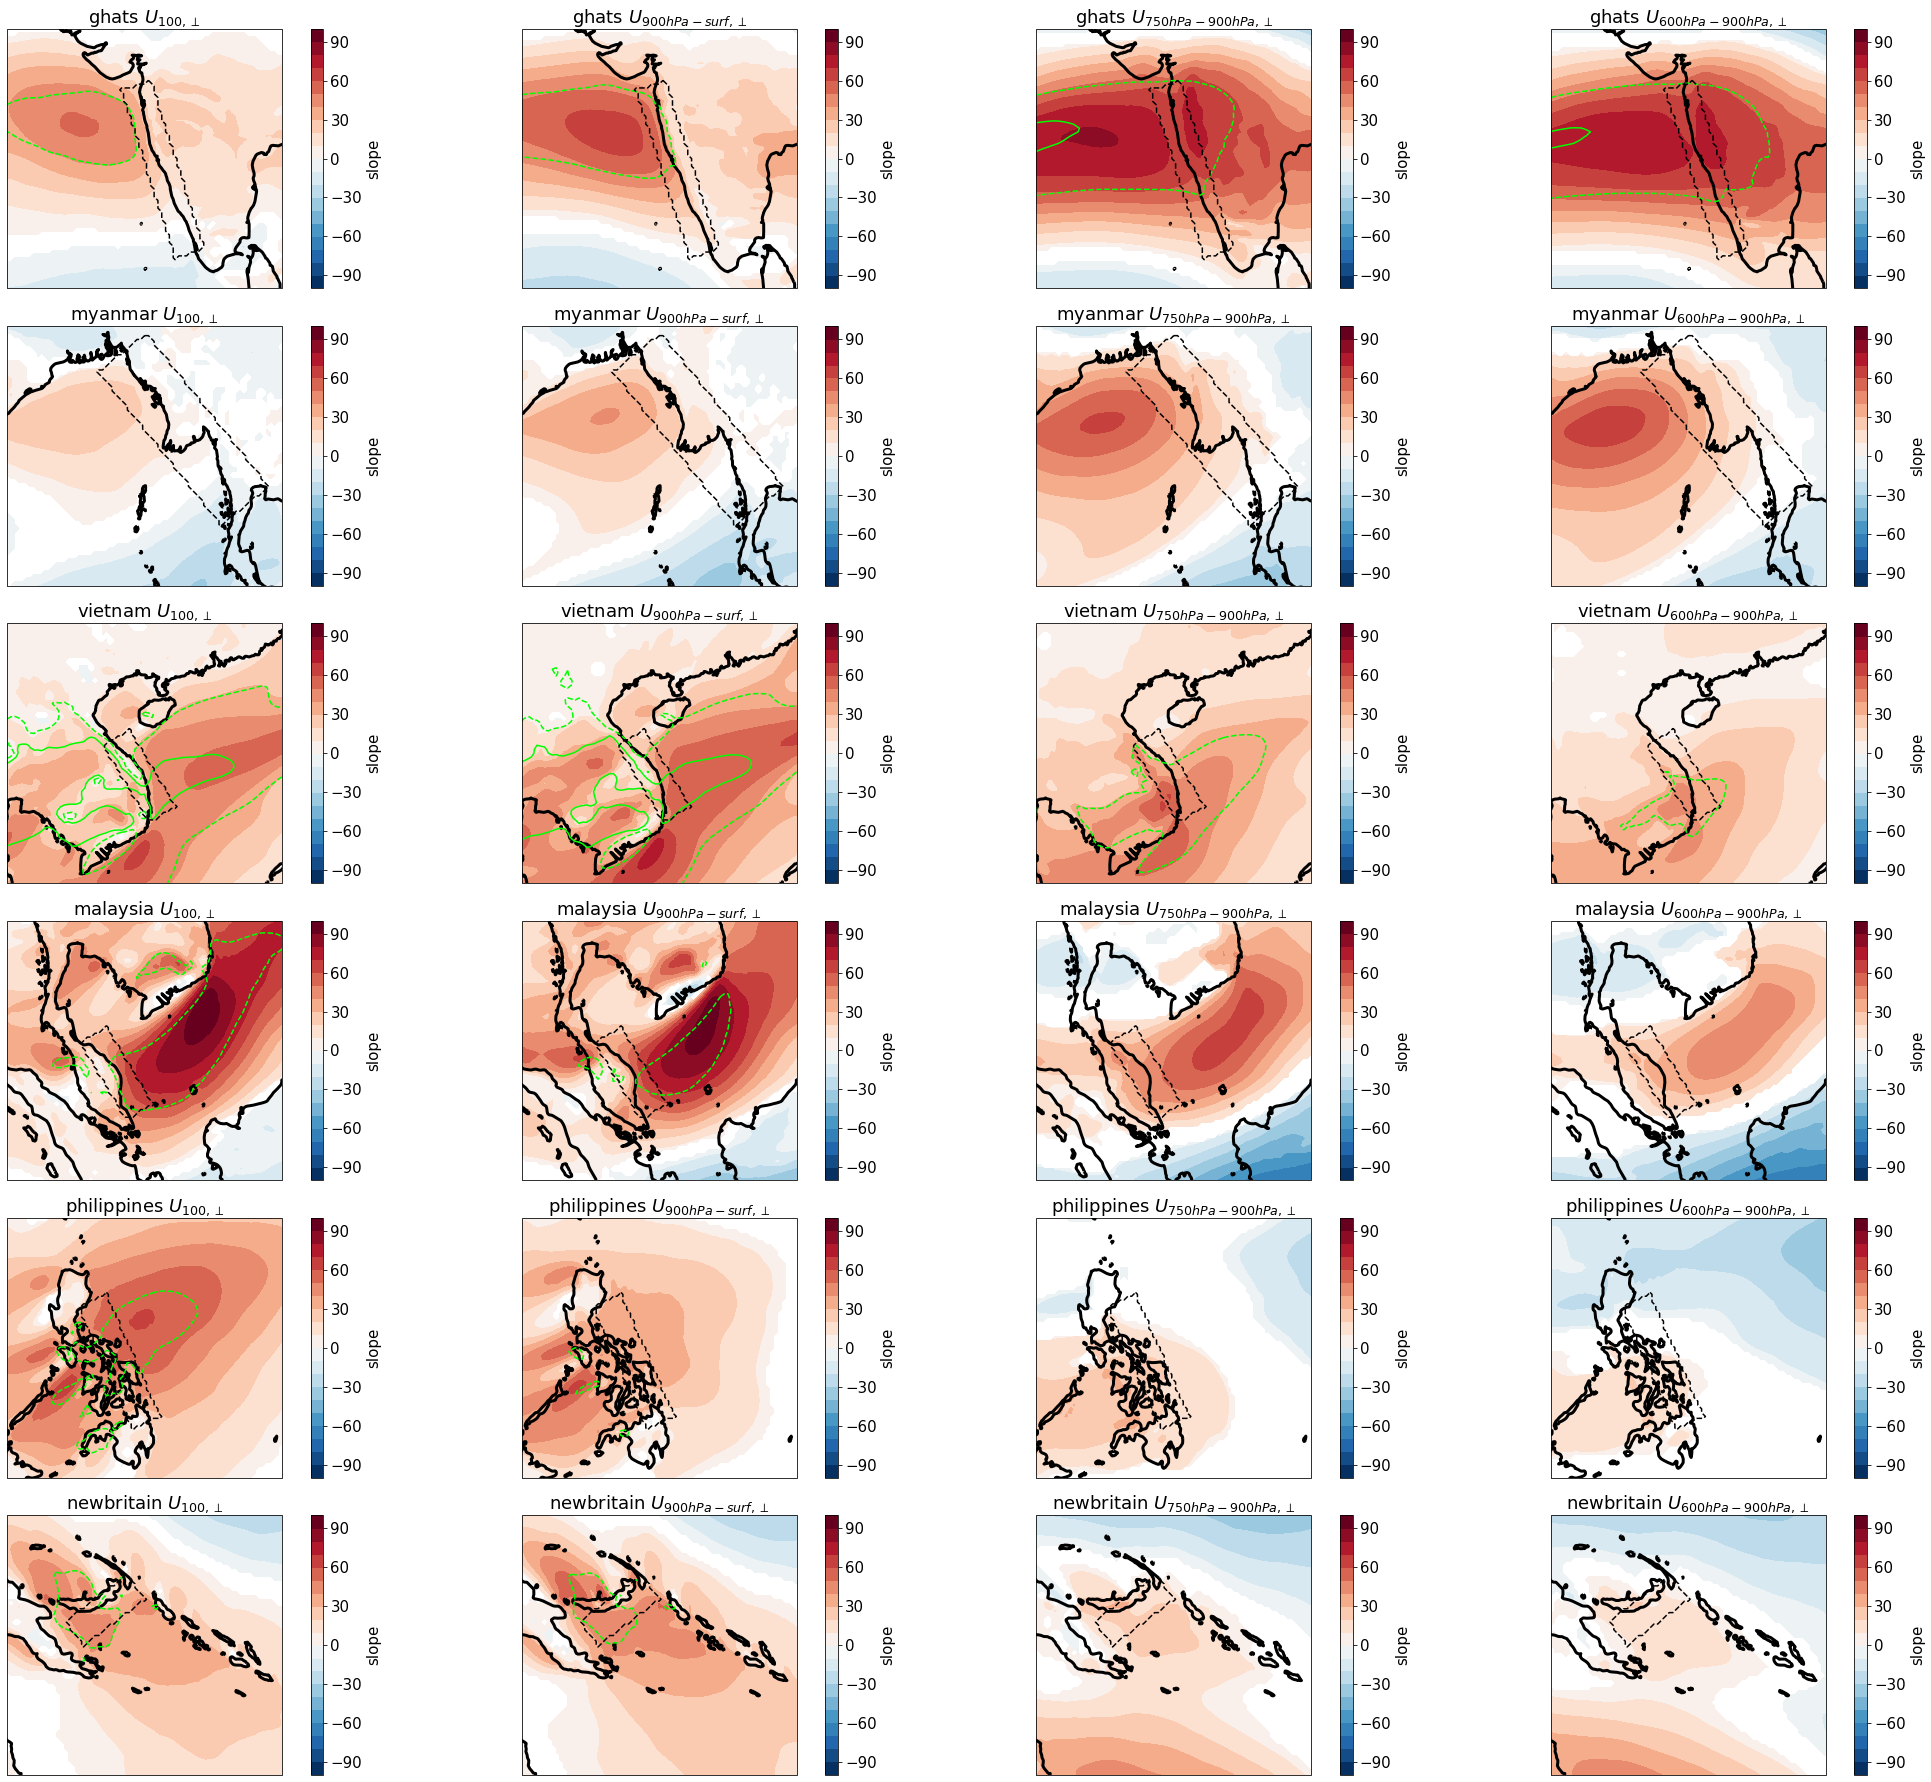

In [18]:
fig,axss = plt.subplots(6,4,figsize=(30,25),subplot_kw={"projection":ccrs.PlateCarree()})
predname = 'TL_ABOVE_DAILY'
cm = plt.cm.RdBu_r

levs=np.linspace(-100,100,21)
for (axs,MR) in zip(axss,MRs):
    predqL = dBLdqL*(MR.vars['QLSEMI_ABOVE_DAILY']-MR.vars['QLSEMI_ABOVE_DAILY'].mean('time'))*2.5e6/1004. 
    predTL = dBLdTL*(MR.vars['TLSEMI_ABOVE_DAILY']-MR.vars['TLSEMI_ABOVE_DAILY'].mean('time'))
    pred = predTL
    for ax,var in zip(axs,(MR.vars['VAR_100U_PERP_DAILY'],
                           MR.vars['UBL_PERP_DAILY'],
                           crossslopeflow(MR.vars['ULL_DAILY'],MR.vars['VLL_DAILY'],MR.angle),
                           crossslopeflow(MR.vars['UL_DAILY' ],MR.vars['VL_DAILY' ],MR.angle))
                     ) :
        reg = linregress_xr_2(pred,var)
    
        plot = reg.slope * 1/(fdr_xr_2d(reg.pvalue,0.1))
        plot.plot.contourf(ax=ax,cmap=cm,levels=levs)
        reg.rsquared.plot.contour(ax=ax,levels=[0.2,0.4],colors=['lime','lime'],linestyles=['--','-'])
        tilted_rect(reg,*MR.box_tilted).plot.contour(ax=ax,levels=[0.5],linestyles=['--'],colors=['k'])
        #plot_box(ax,MR.box_wind)
        ax.coastlines(linewidth=3)
    axs[0].set_title(MR.name + r' $U_{100,\perp}$')
    axs[1].set_title(MR.name + r' $U_{900hPa-surf,\perp}$')
    axs[2].set_title(MR.name + r' $U_{750hPa-900hPa,\perp}$')
    axs[3].set_title(MR.name + r' $U_{600hPa-900hPa,\perp}$')
fig.tight_layout()

ghats       : 20 % variance explained
myanmar     :  2 % variance explained
vietnam     : 42 % variance explained
malaysia    : 16 % variance explained
philippines :  8 % variance explained
newbritain  : 20 % variance explained


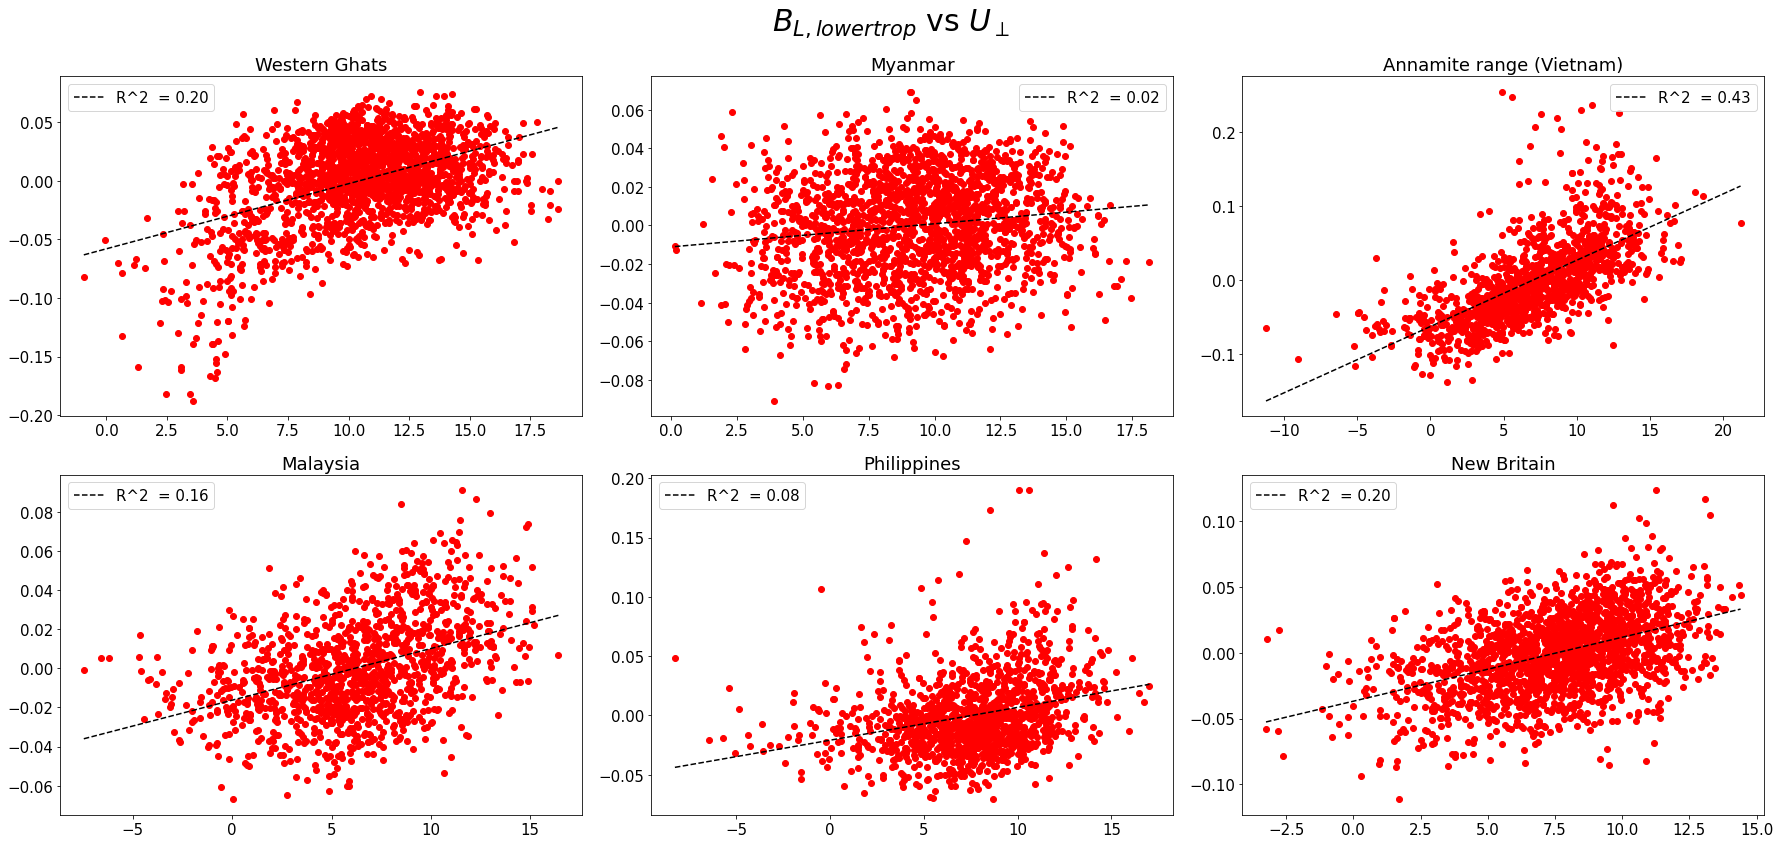

In [73]:
# Magnitude of BL changes explained by Uperp changes

fig,axs = plt.subplots(2,3,figsize=(25,12))
axs=axs.reshape(-1)
for i,MR in enumerate(MRs):
    predqL = dBLdqL*(MR.vars['QLSEMI_ABOVE_DAILY']-MR.vars['QLSEMI_ABOVE_DAILY'].mean('time'))*2.5e6/1004. 
    predTL = dBLdTL*(MR.vars['TLSEMI_ABOVE_DAILY']-MR.vars['TLSEMI_ABOVE_DAILY'].mean('time'))
    pred = predTL
    
    var = MR.vars['UBL_PERP_INTERVAL_DAILY']

    axs[i].scatter(var,pred,color='r')
    x,y,rsq,popt = fit_coefs(np.array(var),np.array(pred),'linear')
    axs[i].plot(x,y,color='k',linestyle='--',label='R^2  = %.2f'%rsq)
    axs[i].set_title(MR.Lname)
    axs[i].legend()
    print('{:<11s} : {:>2d} % variance explained'.format(MR.name,int(100*popt[0]**2*var.var('time')/pred.var('time'))))
    
fig.suptitle(r"$B_{L,lowertrop}$ vs $U_\perp$",fontsize=30)
fig.tight_layout()

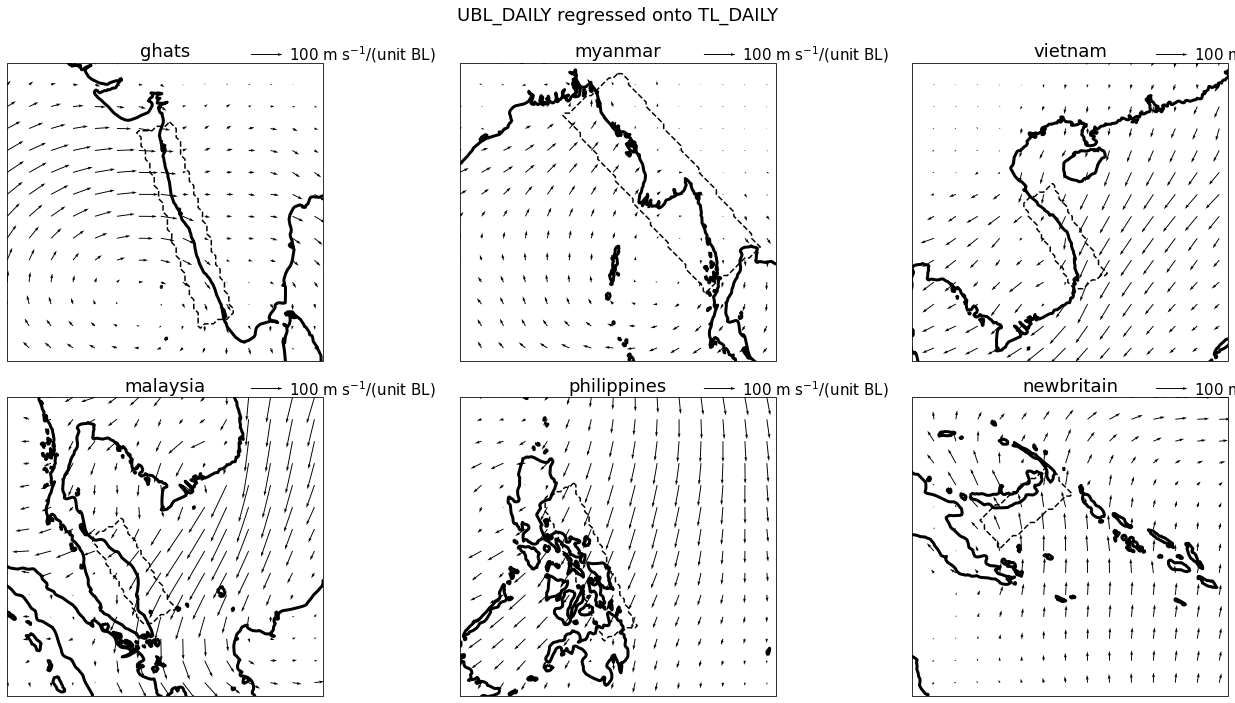

In [80]:
fig,axs = plt.subplots(2,3,figsize=(20,10),subplot_kw={"projection":ccrs.PlateCarree()})
axs=axs.reshape(-1)
predname = 'TL_DAILY'

levs = np.linspace(-60,60,21)
varname = 'UBL_DAILY'

for (ax,MR) in zip(axs,MRs):
    predqL = dBLdqL*(MR.vars['QLSEMI_ABOVE_DAILY']-MR.vars['QLSEMI_ABOVE_DAILY'].mean('time'))*2.5e6/1004. 
    predTL = dBLdTL*(MR.vars['TLSEMI_ABOVE_DAILY']-MR.vars['TLSEMI_ABOVE_DAILY'].mean('time'))
    pred = predTL
    
    u = MR.vars['UBL_DAILY'];v = MR.vars['VBL_DAILY']
    
    ureg = linregress_xr_2(pred,u)
    vreg = linregress_xr_2(pred,v)
    fdrfact = fdr_xr_2d(ureg.pvalue,0.1) + fdr_xr_2d(vreg.pvalue,0.1) >0
    u = ureg.slope /fdrfact;v=vreg.slope /fdrfact
    add_wind(ax,u,v,width=0.003,scale=1000)
    
    tilted_rect(ureg,*MR.box_tilted).plot.contour(ax=ax,levels=[0.5],linestyles=['--'],colors=['k'])
    ax.coastlines(linewidth=3)
    ax.set_title(MR.name)

fig.suptitle(varname + ' regressed onto ' + predname)
fig.tight_layout()

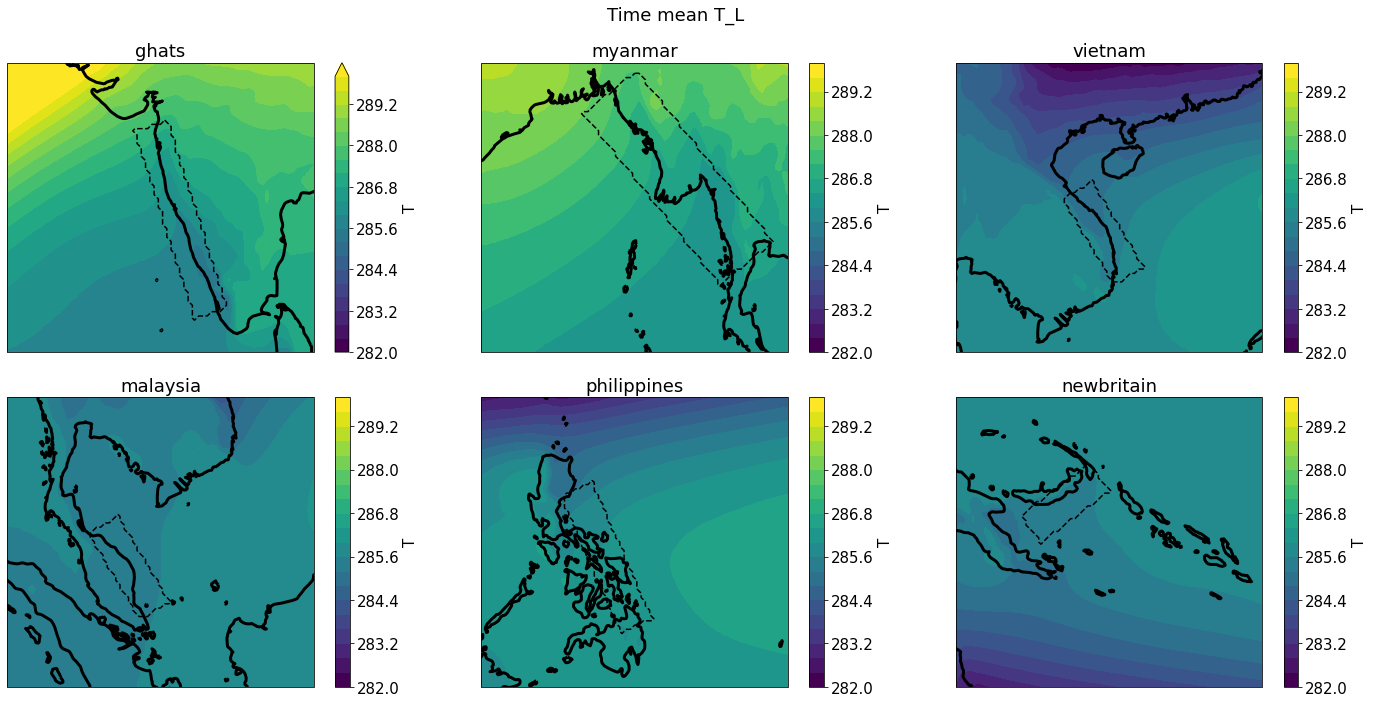

In [88]:
fig,axs = plt.subplots(2,3,figsize=(20,10),subplot_kw={"projection":ccrs.PlateCarree()})
axs=axs.reshape(-1)
for (ax,MR) in zip(axs,MRs):
    plot = MR.vars['TLSEMI_DAILY'].mean('time')
    plot.plot.contourf(ax=ax,levels=np.linspace(282,290,21),transform = ccrs.PlateCarree())
    
    tilted_rect(plot,*MR.box_tilted).plot.contour(ax=ax,levels=[0.5],linestyles=['--'],colors=['k'])
    ax.coastlines(linewidth=3)
    ax.set_title(MR.name)

fig.suptitle("Time mean T_L")
fig.tight_layout()

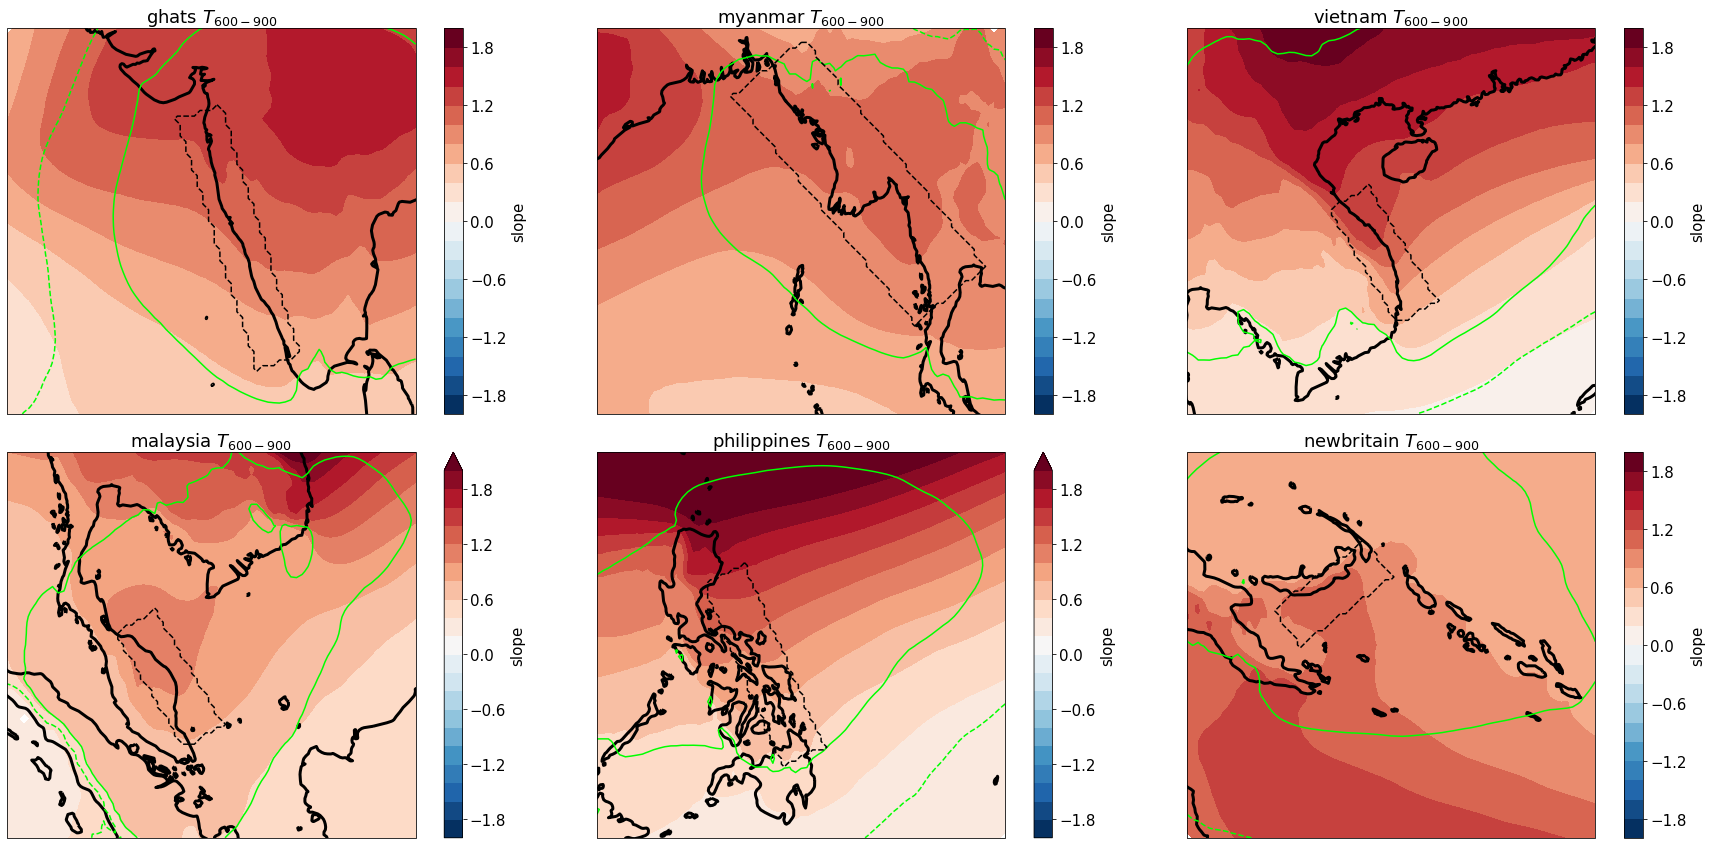

In [118]:
fig,axs = plt.subplots(2,3,figsize=(25,12),subplot_kw={"projection":ccrs.PlateCarree()})
axs=axs.reshape(-1)
cm = plt.cm.RdBu_r#viridis

levs=np.linspace(-2,2,21)
for (ax,MR) in zip(axs,MRs):
    predqL = dBLdqL*(MR.vars['QLSEMI_ABOVE_DAILY']-MR.vars['QLSEMI_ABOVE_DAILY'].mean('time'))*2.5e6/1004. 
    predTL = dBLdTL*(MR.vars['TLSEMI_ABOVE_DAILY']-MR.vars['TLSEMI_ABOVE_DAILY'].mean('time'))
    pred = predTL
    var = dBLdTL*MR.vars['TLSEMI_DAILY']
    reg = linregress_xr_2(pred,var)
    
    plot = reg.slope * 1/(fdr_xr_2d(reg.pvalue,0.1))
    plot.plot.contourf(ax=ax,cmap=cm,levels=levs)
    reg.rsquared.plot.contour(ax=ax,levels=[0.2,0.5],colors=['lime','lime'],linestyles=['--','-'])
    tilted_rect(reg,*MR.box_tilted).plot.contour(ax=ax,levels=[0.5],linestyles=['--'],colors=['k'])
    #plot_box(ax,MR.box_wind)
    ax.coastlines(linewidth=3)
    ax.set_title(MR.name + r' $T_{600-900}$')
fig.tight_layout()

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


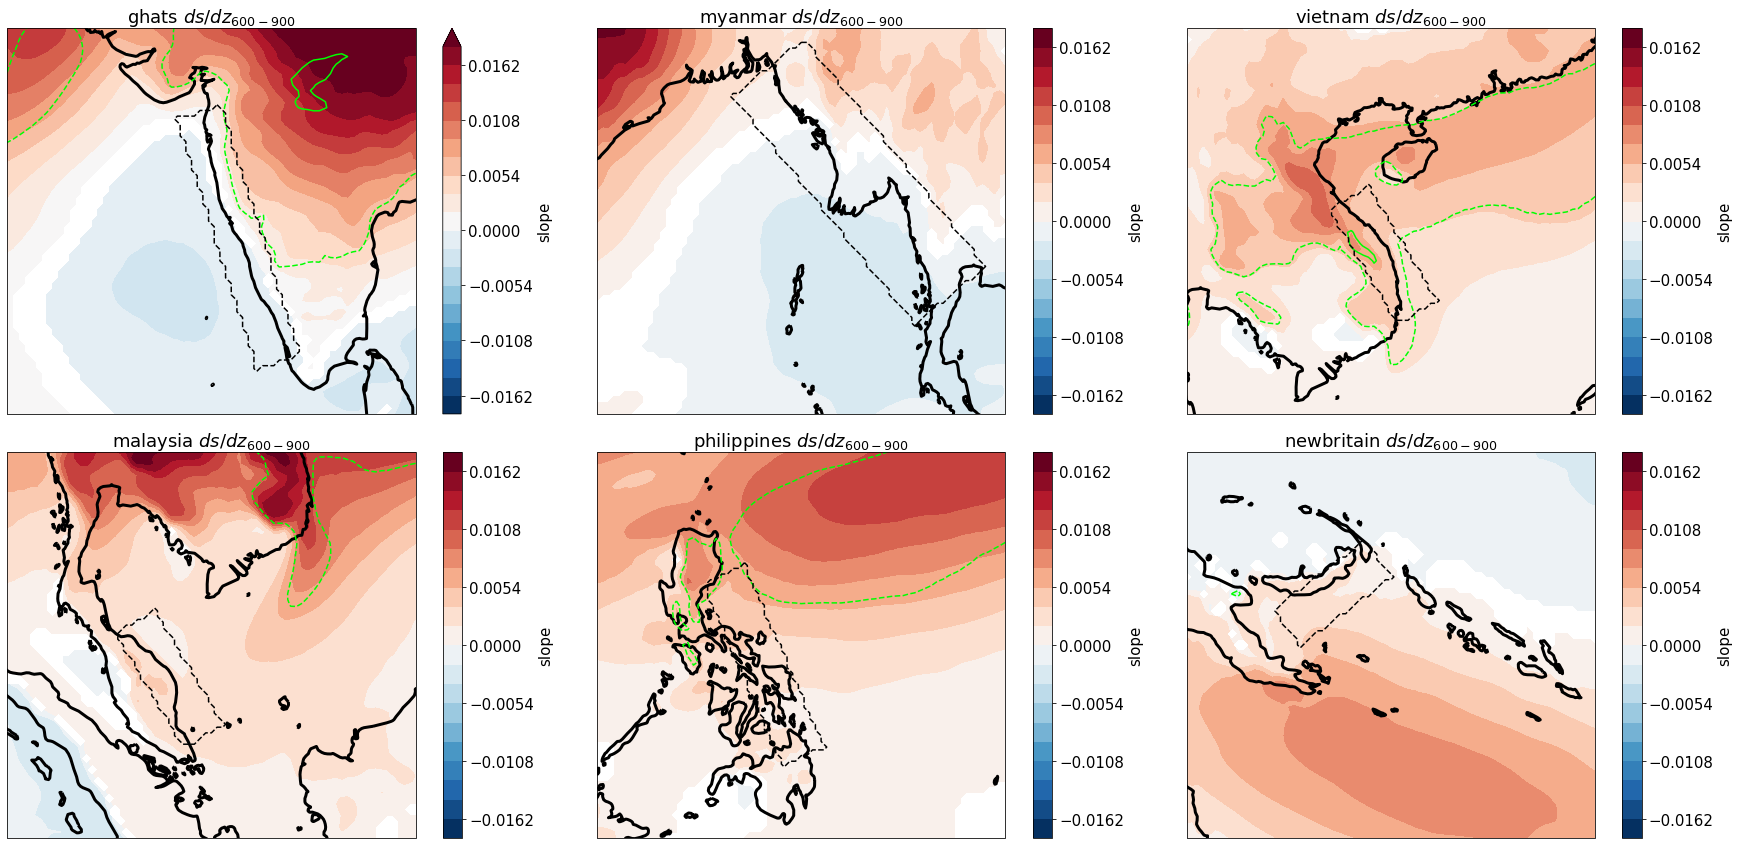

In [54]:
fig,axs = plt.subplots(2,3,figsize=(25,12),subplot_kw={"projection":ccrs.PlateCarree()})
axs=axs.reshape(-1)
cm = plt.cm.RdBu_r#viridis

levs=np.linspace(-0.018,0.018,21)
for (ax,MR) in zip(axs,MRs):
    predqL = dBLdqL*(MR.vars['QLSEMI_ABOVE_DAILY']-MR.vars['QLSEMI_ABOVE_DAILY'].mean('time'))*2.5e6/1004. 
    predTL = dBLdTL*(MR.vars['TLSEMI_ABOVE_DAILY']-MR.vars['TLSEMI_ABOVE_DAILY'].mean('time'))
    pred = predTL
    var = MR.vars['DSDZ_DAILY'].sel(level=slice(600,900)).mean('level')
    reg = linregress_xr_2(pred,var)
    
    plot = reg.slope * 1/(fdr_xr_2d(reg.pvalue,0.1))
    plot.plot.contourf(ax=ax,cmap=cm,levels=levs)
    reg.rsquared.plot.contour(ax=ax,levels=[0.2,0.5],colors=['lime','lime'],linestyles=['--','-'])
    tilted_rect(reg,*MR.box_tilted).plot.contour(ax=ax,levels=[0.5],linestyles=['--'],colors=['k'])
    #plot_box(ax,MR.box_wind)
    ax.coastlines(linewidth=3)
    ax.set_title(MR.name + r' $ds/dz_{600-900}$')
fig.tight_layout()

# Regressing $q_L'$

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


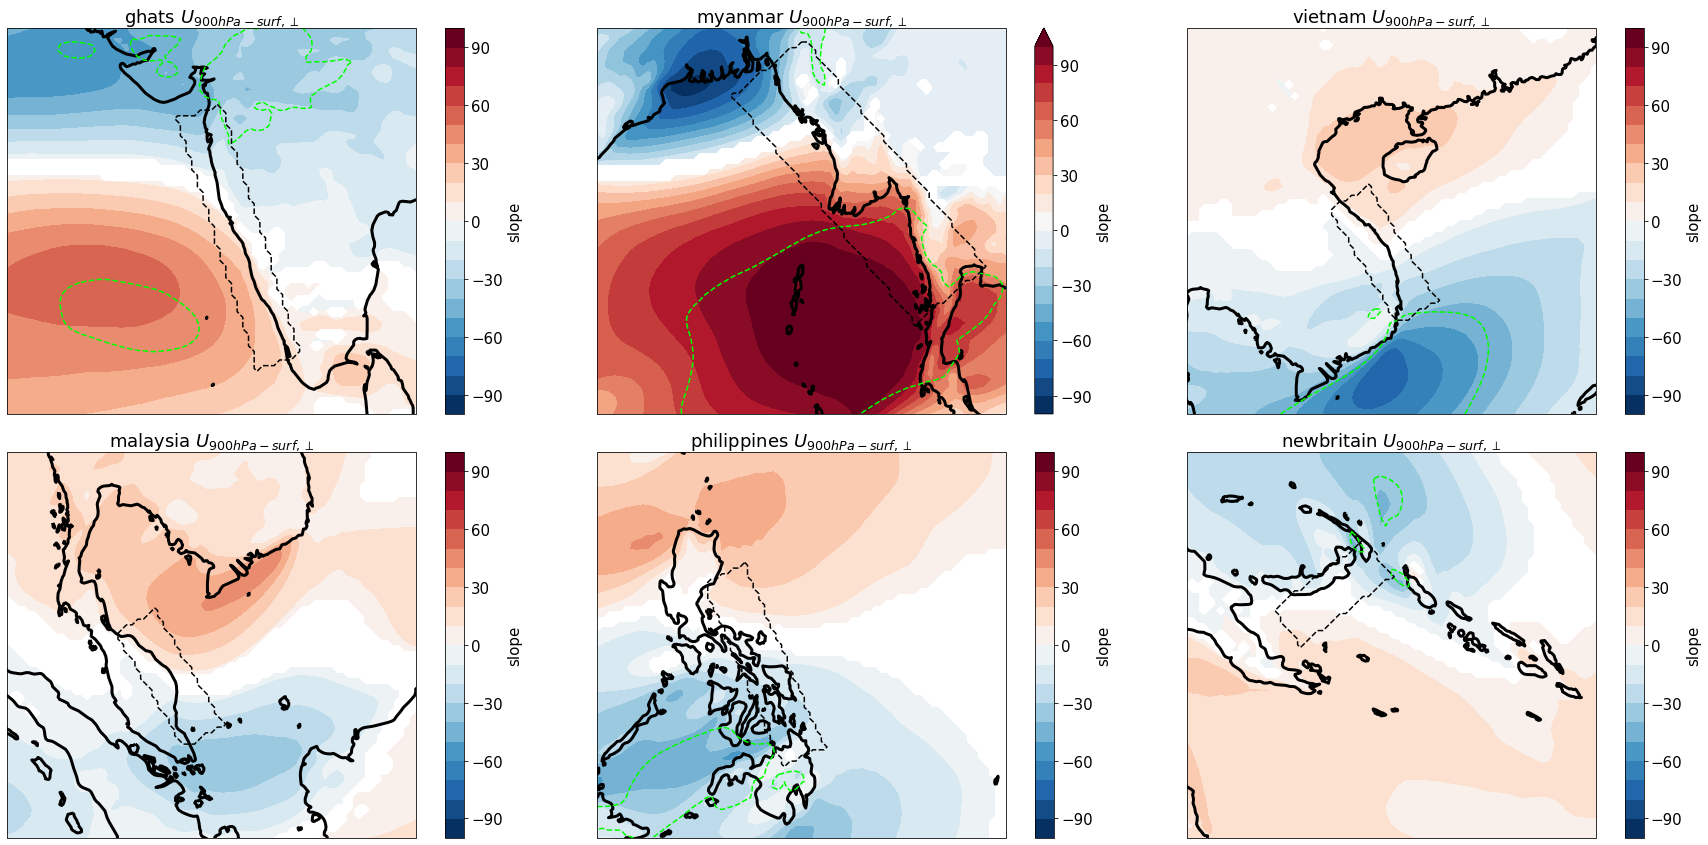

In [58]:
fig,axs = plt.subplots(2,3,figsize=(25,12),subplot_kw={"projection":ccrs.PlateCarree()})
axs=axs.reshape(-1)
cm = plt.cm.RdBu_r#viridis

levs=np.linspace(-100,100,21)
for (ax,MR) in zip(axs,MRs):
    predqL = dBLdqL*(MR.vars['QLSEMI_ABOVE_DAILY']-MR.vars['QLSEMI_ABOVE_DAILY'].mean('time'))*2.5e6/1004. 
    predTL = dBLdTL*(MR.vars['TLSEMI_ABOVE_DAILY']-MR.vars['TLSEMI_ABOVE_DAILY'].mean('time'))
    pred = predqL
    var = MR.vars['UBL_PERP_DAILY']
    reg = linregress_xr_2(pred,var)
    
    plot = reg.slope * 1/(fdr_xr_2d(reg.pvalue,0.1))
    plot.plot.contourf(ax=ax,cmap=cm,levels=levs)
    reg.rsquared.plot.contour(ax=ax,levels=[0.2,0.4],colors=['lime','lime'],linestyles=['--','-'])
    tilted_rect(reg,*MR.box_tilted).plot.contour(ax=ax,levels=[0.5],linestyles=['--'],colors=['k'])
    #plot_box(ax,MR.box_wind)
    ax.coastlines(linewidth=3)
    ax.set_title(MR.name + r' $U_{900hPa-surf,\perp}$')
fig.tight_layout()

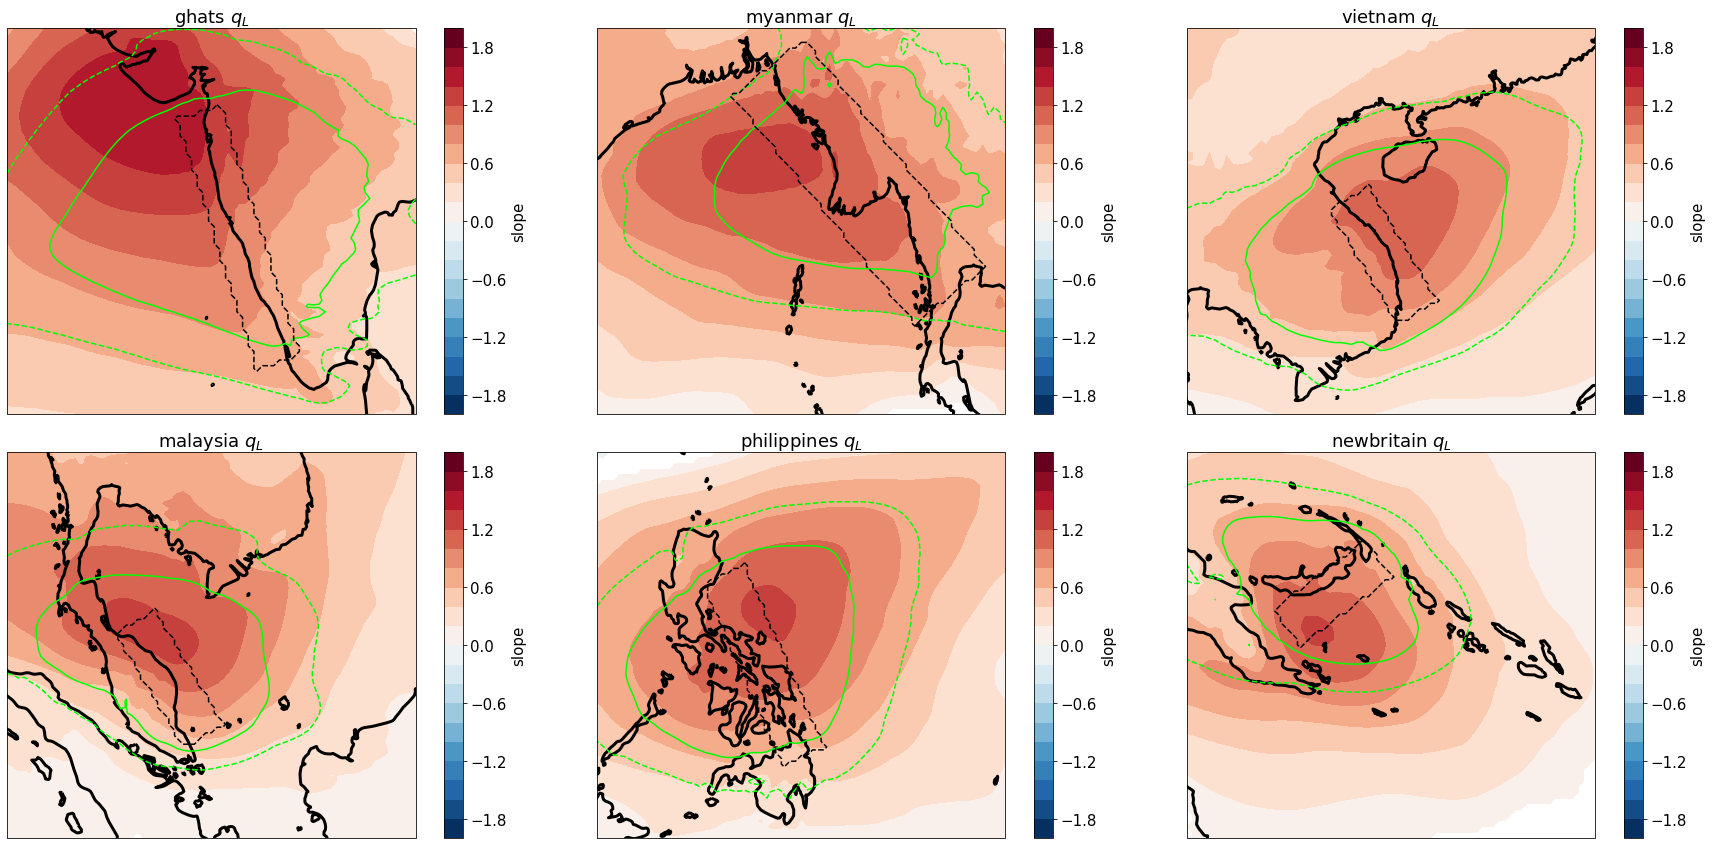

In [119]:
fig,axs = plt.subplots(2,3,figsize=(25,12),subplot_kw={"projection":ccrs.PlateCarree()})
axs=axs.reshape(-1)
cm = plt.cm.RdBu_r#viridis

levs=np.linspace(-2,2,21)
for (ax,MR) in zip(axs,MRs):
    predqL = dBLdqL*(MR.vars['QLSEMI_ABOVE_DAILY']-MR.vars['QLSEMI_ABOVE_DAILY'].mean('time'))*2.5e6/1004. 
    predTL = dBLdTL*(MR.vars['TLSEMI_ABOVE_DAILY']-MR.vars['TLSEMI_ABOVE_DAILY'].mean('time'))
    pred = predqL
    var = dBLdqL*MR.vars['QLSEMI_DAILY']*2.5e6/1004. 
    reg = linregress_xr_2(pred,var)
    
    plot = reg.slope * 1/(fdr_xr_2d(reg.pvalue,0.1))
    plot.plot.contourf(ax=ax,cmap=cm,levels=levs)
    reg.rsquared.plot.contour(ax=ax,levels=[0.2,0.4],colors=['lime','lime'],linestyles=['--','-'])
    tilted_rect(reg,*MR.box_tilted).plot.contour(ax=ax,levels=[0.5],linestyles=['--'],colors=['k'])
    #plot_box(ax,MR.box_wind)
    ax.coastlines(linewidth=3)
    ax.set_title(MR.name + r' $q_{L}$')
fig.tight_layout()

CPU times: user 13.6 s, sys: 2.48 s, total: 16.1 s
Wall time: 10.5 s


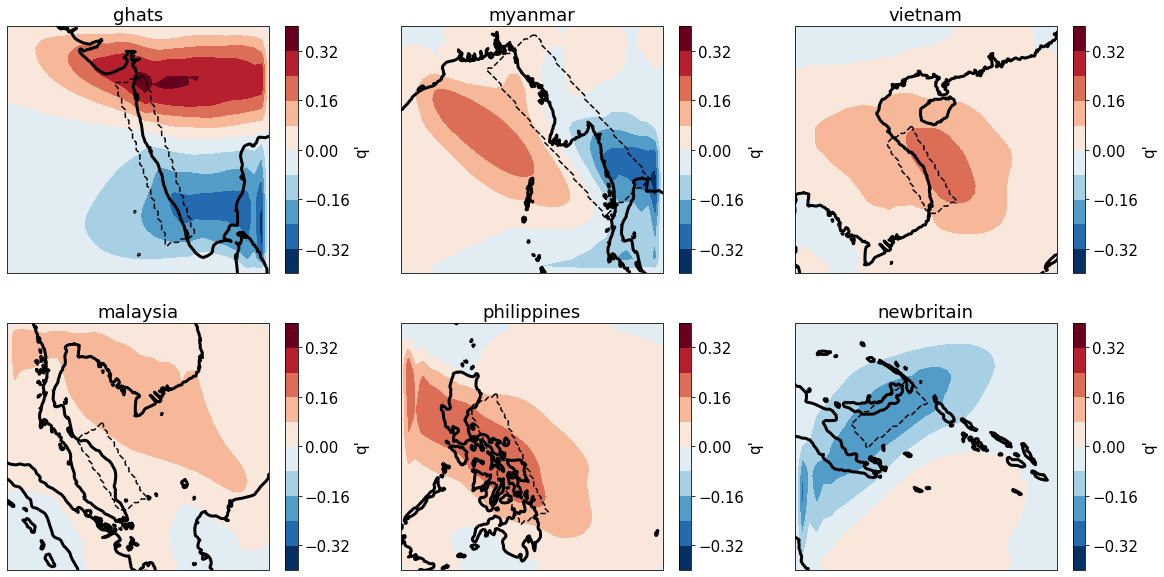

In [166]:
%%time
fig,axs = plt.subplots(2,3,figsize=(20,10),subplot_kw={"projection":ccrs.PlateCarree()})
axs=axs.reshape(-1)
predname = 'QL_DAILY'

for (ax,MR) in zip(axs,MRs):
    predqL = dBLdqL*(MR.vars['QLSEMI_ABOVE_DAILY']-MR.vars['QLSEMI_ABOVE_DAILY'].mean('time'))*2.5e6/1004. 
    pred = predqL
    u = MR.vars['UBL_DAILY'];v = MR.vars['VBL_DAILY']
    ureg = linregress_xr_2(pred,u).slope
    vreg = linregress_xr_2(pred,v).slope
    qmean = MR.vars['QLSEMI_DAILY'].mean('time')
    umean = MR.vars['UBL_DAILY'].mean('time')
    vmean = MR.vars['VBL_DAILY'].mean('time')
    
    kappa = 5e4
    upgradq = ureg * qmean.differentiate('longitude')/110e3 + vreg * qmean.differentiate('latitude')/110e3
    down=2
    qprime = dBLdqL*2.5e3*solve_advdiff(umean[::down,::down],vmean[::down,::down],kappa,upgradq[::down,::down],bc='dirichlet')
    qprime.plot.contourf(ax=ax,levels=np.linspace(-0.4,0.4,11))

    tilted_rect(ureg,*MR.box_tilted).plot.contour(ax=ax,levels=[0.5],linestyles=['--'],colors=['k'])
    ax.coastlines(linewidth=3)
    ax.set_title(MR.name)

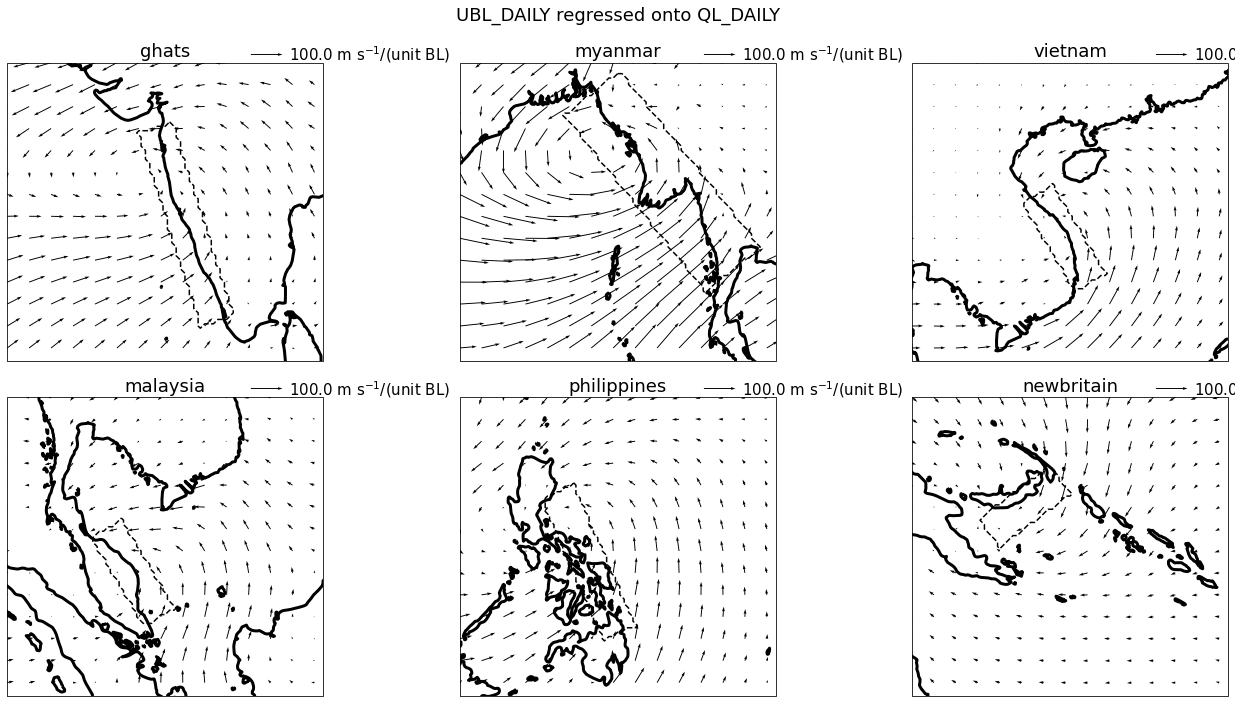

In [140]:
fig,axs = plt.subplots(2,3,figsize=(20,10),subplot_kw={"projection":ccrs.PlateCarree()})
axs=axs.reshape(-1)
predname = 'QL_DAILY'

levs = np.linspace(-60,60,21)
varname = 'UBL_DAILY'

for (ax,MR) in zip(axs,MRs):
    predqL = dBLdqL*(MR.vars['QLSEMI_ABOVE_DAILY']-MR.vars['QLSEMI_ABOVE_DAILY'].mean('time'))*2.5e6/1004. 
    predTL = dBLdTL*(MR.vars['TLSEMI_ABOVE_DAILY']-MR.vars['TLSEMI_ABOVE_DAILY'].mean('time'))
    pred = predqL
    
    u = MR.vars['UBL_DAILY'];v = MR.vars['VBL_DAILY']
    
    ureg = linregress_xr_2(pred,u)
    vreg = linregress_xr_2(pred,v)
    fdrfact = fdr_xr_2d(ureg.pvalue,0.1) + fdr_xr_2d(vreg.pvalue,0.1) >0
    #fdrfact = fdr_xr_2d(linregress_xr_2(pred,np.sqrt(u**2+v**2)).pvalue,0.1)
    u = ureg.slope /fdrfact;v=vreg.slope /fdrfact
    add_wind(ax,u,v,width=0.003,scale=1000)
    
    tilted_rect(ureg,*MR.box_tilted).plot.contour(ax=ax,levels=[0.5],linestyles=['--'],colors=['k'])
    ax.coastlines(linewidth=3)
    ax.set_title(MR.name)

fig.suptitle(varname + ' regressed onto ' + predname)
fig.tight_layout()

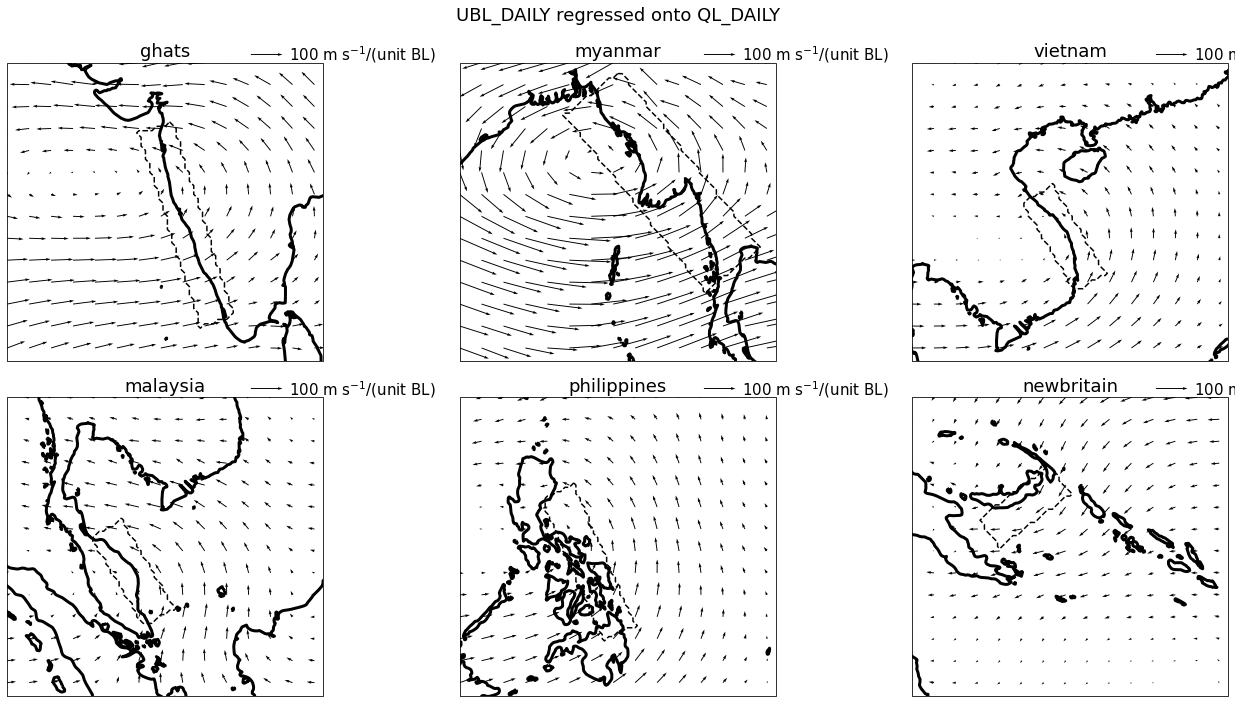

In [34]:
fig,axs = plt.subplots(2,3,figsize=(20,10),subplot_kw={"projection":ccrs.PlateCarree()})
axs=axs.reshape(-1)
predname = 'QL_DAILY'

levs = np.linspace(-60,60,21)
varname = 'UBL_DAILY'

for (ax,MR) in zip(axs,MRs):
    predqL = dBLdqL*(MR.vars['QLSEMI_ABOVE_DAILY']-MR.vars['QLSEMI_ABOVE_DAILY'].mean('time'))*2.5e6/1004. 
    predTL = dBLdTL*(MR.vars['TLSEMI_ABOVE_DAILY']-MR.vars['TLSEMI_ABOVE_DAILY'].mean('time'))
    pred = predqL
    
    u = MR.vars['ULL_DAILY'];v = MR.vars['VLL_DAILY']
    
    ureg = linregress_xr_2(pred,u)
    vreg = linregress_xr_2(pred,v)
    fdrfact = fdr_xr_2d(ureg.pvalue,0.1) + fdr_xr_2d(vreg.pvalue,0.1) >0
    #fdrfact = fdr_xr_2d(linregress_xr_2(pred,np.sqrt(u**2+v**2)).pvalue,0.1)
    u = ureg.slope /fdrfact;v=vreg.slope /fdrfact
    add_wind(ax,u,v,width=0.003,scale=1000)
    
    tilted_rect(ureg,*MR.box_tilted).plot.contour(ax=ax,levels=[0.5],linestyles=['--'],colors=['k'])
    ax.coastlines(linewidth=3)
    ax.set_title(MR.name)

fig.suptitle(varname + ' regressed onto ' + predname)
fig.tight_layout()

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


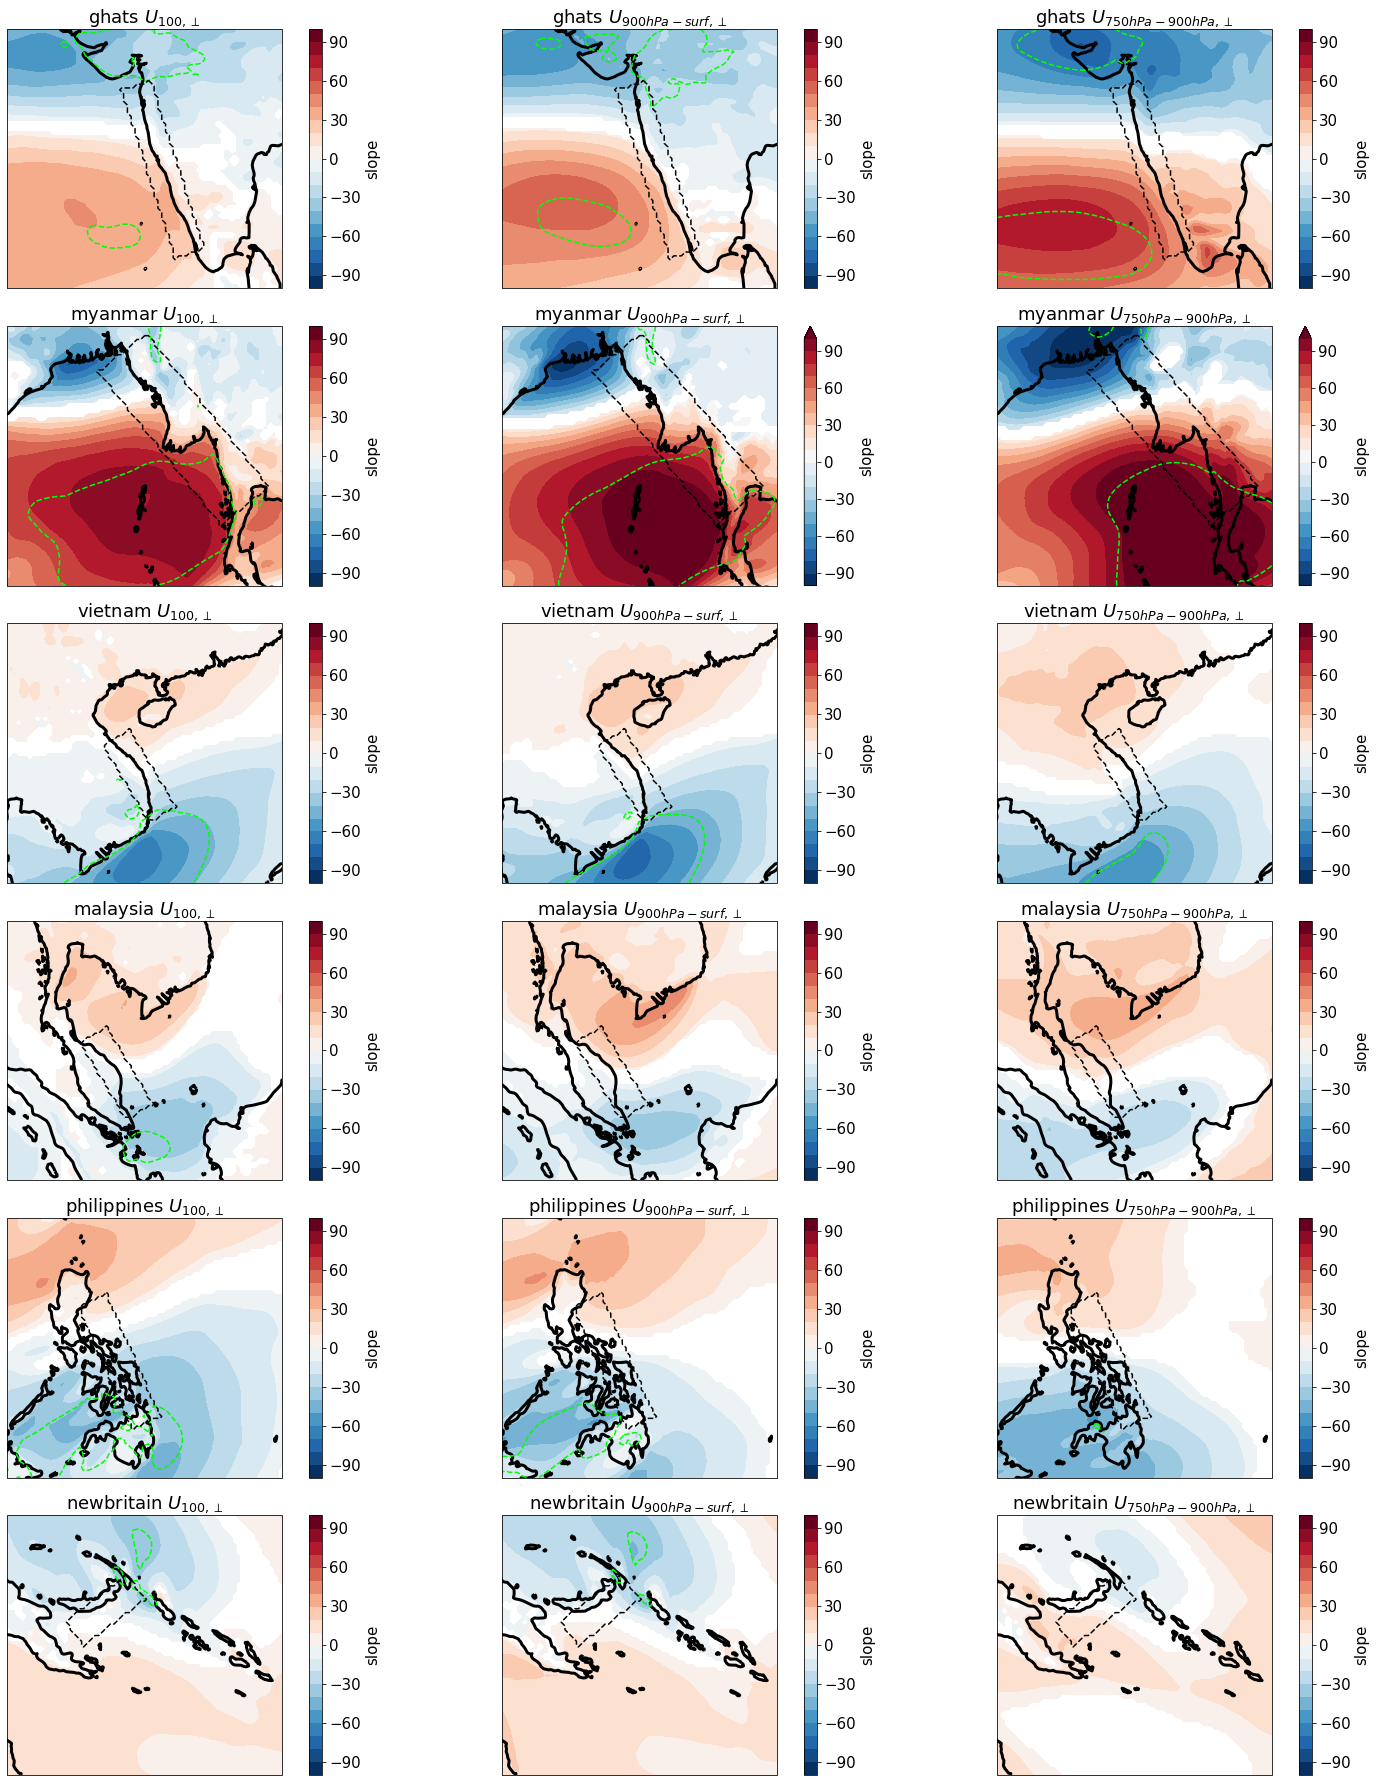

In [22]:
fig,axss = plt.subplots(6,3,figsize=(22,25),subplot_kw={"projection":ccrs.PlateCarree()})
predname = 'QL_ABOVE_DAILY'
cm = plt.cm.RdBu_r

levs=np.linspace(-100,100,21)
for (axs,MR) in zip(axss,MRs):
    predqL = dBLdqL*(MR.vars['QLSEMI_ABOVE_DAILY']-MR.vars['QLSEMI_ABOVE_DAILY'].mean('time'))*2.5e6/1004. 
    predTL = dBLdTL*(MR.vars['TLSEMI_ABOVE_DAILY']-MR.vars['TLSEMI_ABOVE_DAILY'].mean('time'))
    pred = predqL
    for ax,var in zip(axs,(MR.vars['VAR_100U_PERP_DAILY'],
                           MR.vars['UBL_PERP_DAILY'],
                           crossslopeflow(MR.vars['ULL_DAILY'],MR.vars['VLL_DAILY'],MR.angle))
                     ) :
        reg = linregress_xr_2(pred,var)
    
        plot = reg.slope * 1/(fdr_xr_2d(reg.pvalue,0.1))
        plot.plot.contourf(ax=ax,cmap=cm,levels=levs)
        reg.rsquared.plot.contour(ax=ax,levels=[0.2,0.4],colors=['lime','lime'],linestyles=['--','-'])
        tilted_rect(reg,*MR.box_tilted).plot.contour(ax=ax,levels=[0.5],linestyles=['--'],colors=['k'])
        #plot_box(ax,MR.box_wind)
        ax.coastlines(linewidth=3)
    axs[0].set_title(MR.name + r' $U_{100,\perp}$')
    axs[1].set_title(MR.name + r' $U_{900hPa-surf,\perp}$')
    axs[2].set_title(MR.name + r' $U_{750hPa-900hPa,\perp}$')
fig.tight_layout()

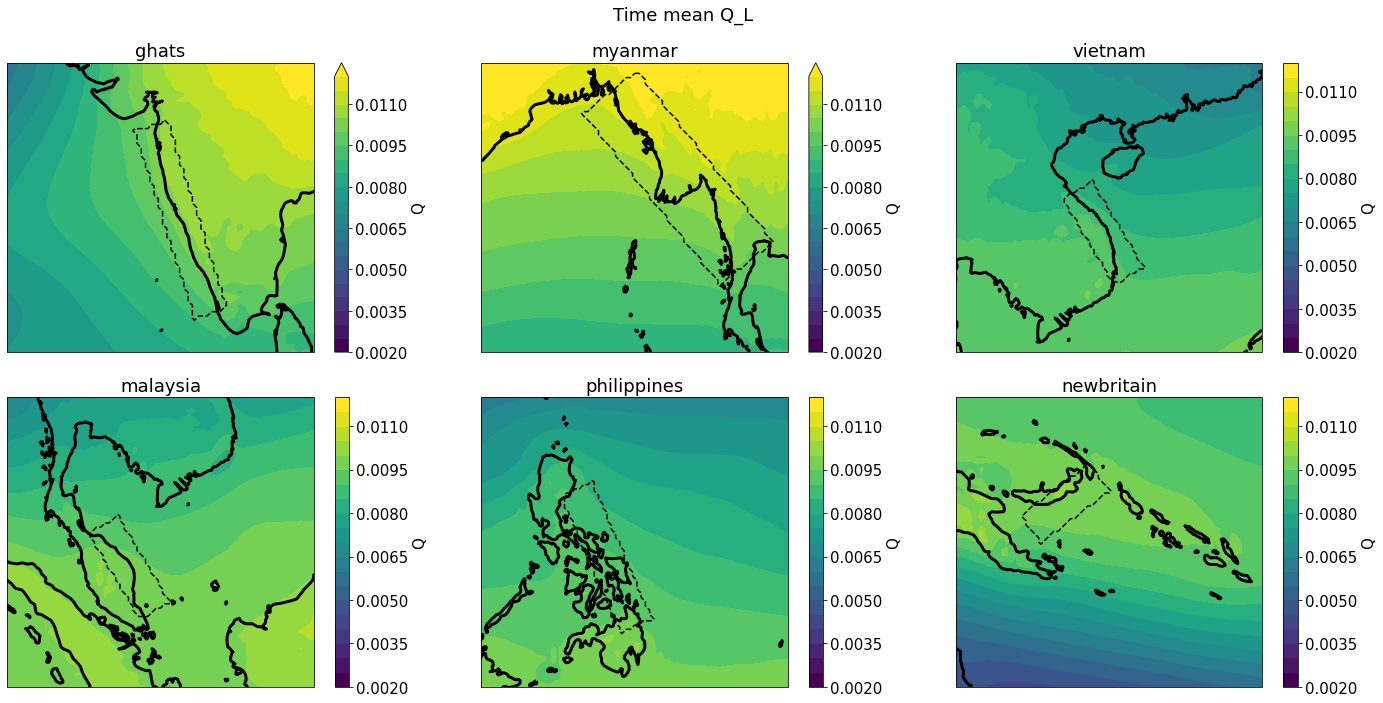

In [28]:
fig,axs = plt.subplots(2,3,figsize=(20,10),subplot_kw={"projection":ccrs.PlateCarree()})
axs=axs.reshape(-1)
for (ax,MR) in zip(axs,MRs):
    plot = MR.vars['QLSEMI_DAILY'].mean('time')
    plot.plot.contourf(ax=ax,levels=np.linspace(2e-3,12e-3,21),transform = ccrs.PlateCarree())
    
    tilted_rect(plot,*MR.box_tilted).plot.contour(ax=ax,levels=[0.5],linestyles=['--'],colors=['k'])
    ax.coastlines(linewidth=3)
    ax.set_title(MR.name)

fig.suptitle("Time mean Q_L")
fig.tight_layout()

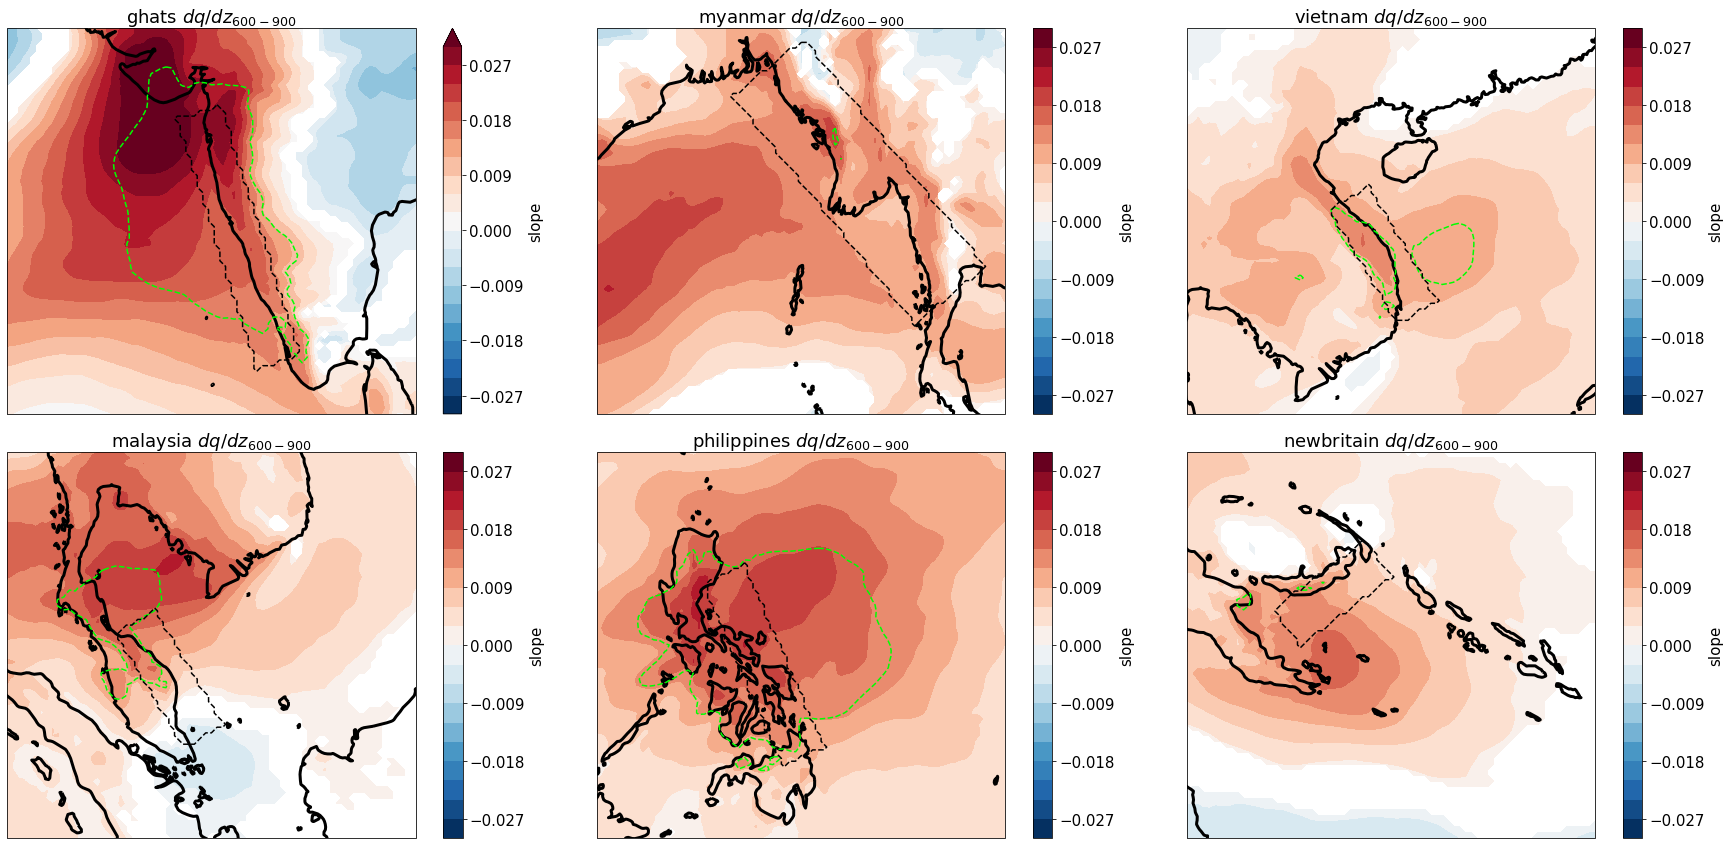

In [59]:
fig,axs = plt.subplots(2,3,figsize=(25,12),subplot_kw={"projection":ccrs.PlateCarree()})
axs=axs.reshape(-1)
cm = plt.cm.RdBu_r#viridis

levs=np.linspace(-0.03,0.03,21)
for (ax,MR) in zip(axs,MRs):
    predqL = dBLdqL*(MR.vars['QLSEMI_ABOVE_DAILY']-MR.vars['QLSEMI_ABOVE_DAILY'].mean('time'))*2.5e6/1004. 
    predTL = dBLdTL*(MR.vars['TLSEMI_ABOVE_DAILY']-MR.vars['TLSEMI_ABOVE_DAILY'].mean('time'))
    pred = predqL
    var = MR.vars['DQDZ_DAILY'].sel(level=slice(600,900)).mean('level')
    reg = linregress_xr_2(pred,var)
    
    plot = reg.slope * 1/(fdr_xr_2d(reg.pvalue,0.1))
    plot.plot.contourf(ax=ax,cmap=cm,levels=levs)
    reg.rsquared.plot.contour(ax=ax,levels=[0.2,0.5],colors=['lime','lime'],linestyles=['--','-'])
    tilted_rect(reg,*MR.box_tilted).plot.contour(ax=ax,levels=[0.5],linestyles=['--'],colors=['k'])
    #plot_box(ax,MR.box_wind)
    ax.coastlines(linewidth=3)
    ax.set_title(MR.name + r' $dq/dz_{600-900}$')
fig.tight_layout()

ghats       : 48 % variance explained
myanmar     : 12 % variance explained
vietnam     : 28 % variance explained
malaysia    :  9 % variance explained
philippines : 48 % variance explained
newbritain  : 13 % variance explained


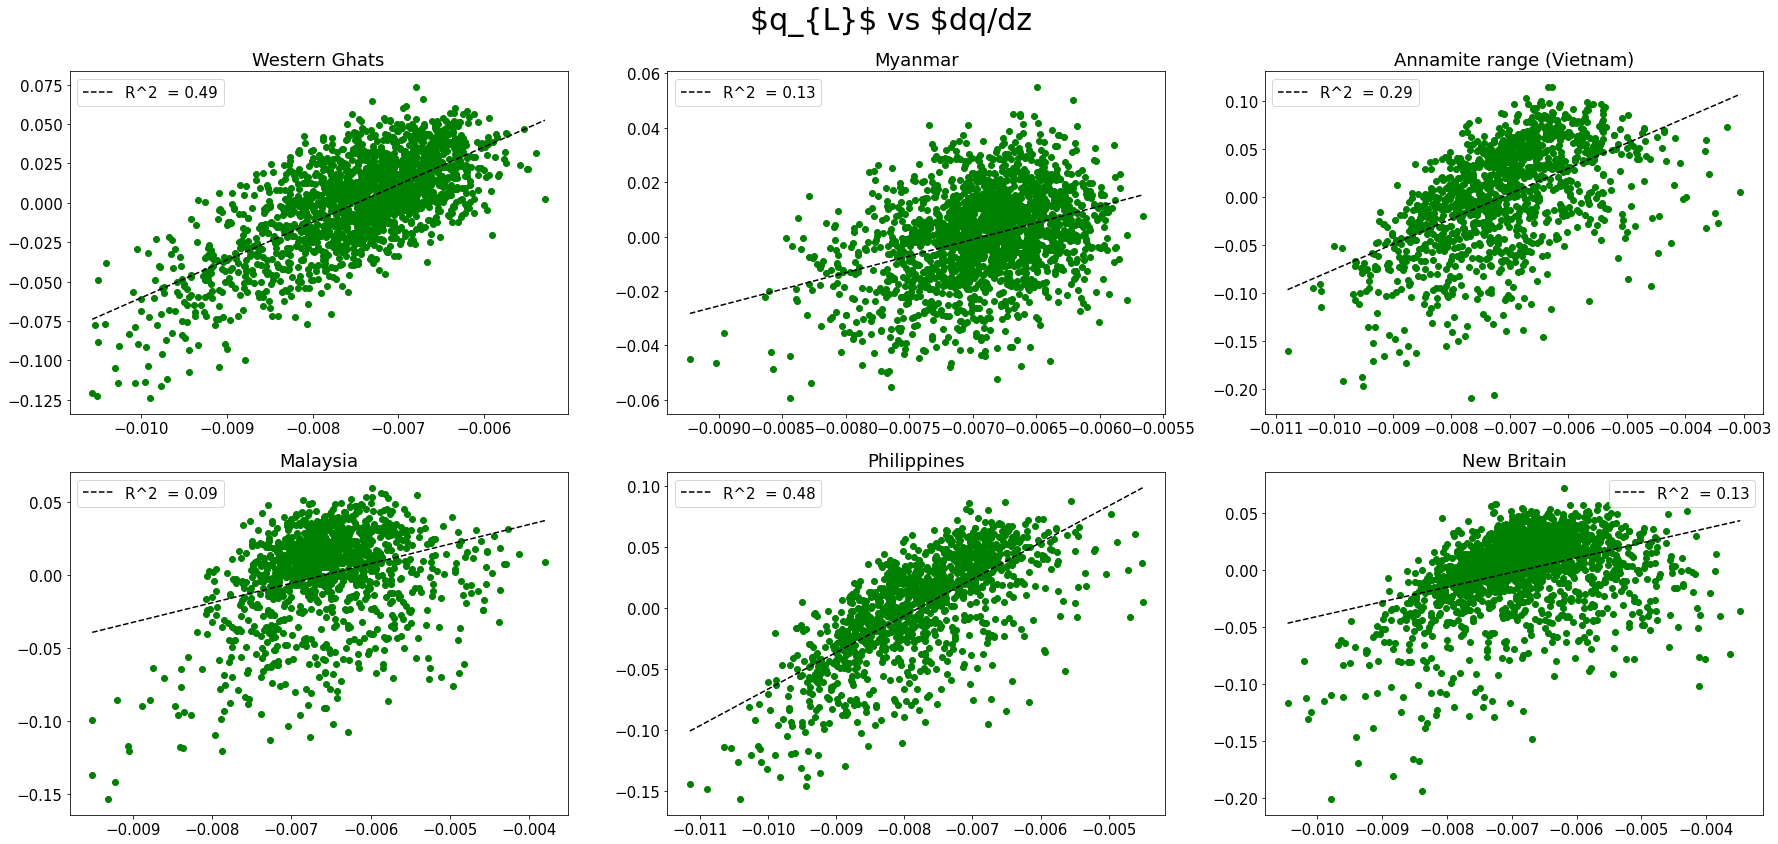

In [24]:
# Magnitude of BL changes explained by Uperp changes

fig,axs = plt.subplots(2,3,figsize=(25,12))
axs=axs.reshape(-1)
for i,MR in enumerate(MRs):
    predqL = dBLdqL*(MR.vars['QLSEMI_ABOVE_DAILY']-MR.vars['QLSEMI_ABOVE_DAILY'].mean('time'))*2.5e6/1004. 
    predTL = dBLdTL*(MR.vars['TLSEMI_ABOVE_DAILY']-MR.vars['TLSEMI_ABOVE_DAILY'].mean('time'))
    pred = predqL
    
    var = MR.vars['DQDZ_ABOVE_DAILY'].sel(level=slice(600,900)).mean('level')

    axs[i].scatter(var,pred,color='g')
    x,y,rsq,popt = fit_coefs(np.array(var),np.array(pred),'linear')
    axs[i].plot(x,y,color='k',linestyle='--',label='R^2  = %.2f'%rsq)
    axs[i].set_title(MR.Lname)
    axs[i].legend()
    print('{:<11s} : {:>2d} % variance explained'.format(MR.name,int(100*popt[0]**2*var.var('time')/pred.var('time'))))
    
fig.suptitle(r"$q_{L}$ vs $dq/dz",fontsize=30)
fig.tight_layout()

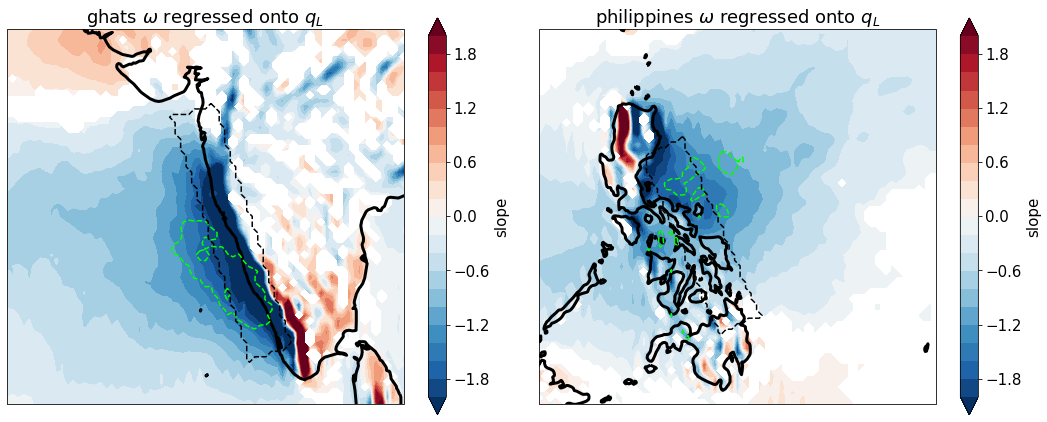

In [139]:
fig,axs = plt.subplots(1,2,figsize=(15,6),subplot_kw={"projection":ccrs.PlateCarree()})
axs=axs.reshape(-1)
cm = plt.cm.RdBu_r#viridis

levs=np.linspace(-2,2,21)
for (ax,MR) in zip(axs,(Ghats, Philippines)):
    predqL = dBLdqL*(MR.vars['QLSEMI_ABOVE_DAILY']-MR.vars['QLSEMI_ABOVE_DAILY'].mean('time'))*2.5e6/1004. 
    predTL = dBLdTL*(MR.vars['TLSEMI_ABOVE_DAILY']-MR.vars['TLSEMI_ABOVE_DAILY'].mean('time'))
    pred = predqL
    var = MR.vars['WL_DAILY']
    reg = linregress_xr_2(pred,var)
    
    plot = reg.slope * 1/(fdr_xr_2d(reg.pvalue,0.1))
    plot.plot.contourf(ax=ax,cmap=cm,levels=levs)
    reg.rsquared.plot.contour(ax=ax,levels=[0.2,0.5],colors=['lime','lime'],linestyles=['--','-'])
    tilted_rect(reg,*MR.box_tilted).plot.contour(ax=ax,levels=[0.5],linestyles=['--'],colors=['k'])
    #plot_box(ax,MR.box_wind)
    ax.coastlines(linewidth=3)
    ax.set_title(MR.name + r' $\omega$ regressed onto $q_L$')
fig.tight_layout()

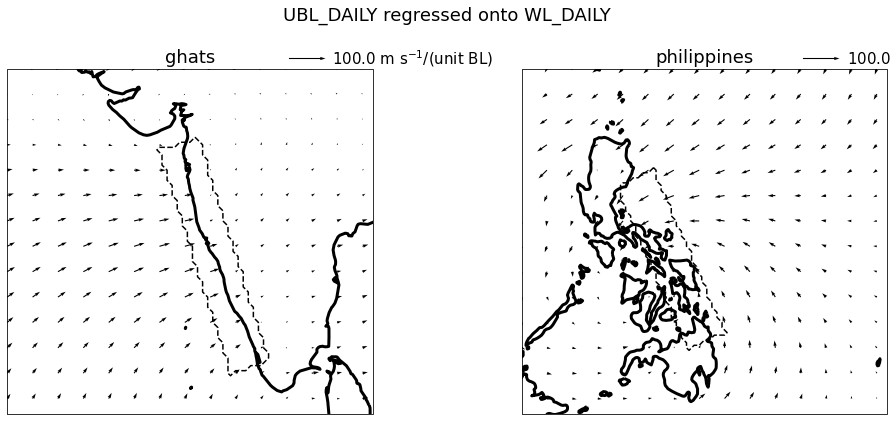

In [137]:
fig,axs = plt.subplots(1,2,figsize=(15,6),subplot_kw={"projection":ccrs.PlateCarree()})
axs=axs.reshape(-1)
predname = 'WL_DAILY'

levs = np.linspace(-60,60,21)
varname = 'UBL_DAILY'

for (ax,MR) in zip(axs,(Ghats, Philippines)):
    pred = -MR.vars['WL_ABOVE_DAILY']
    
    u = MR.vars['UBL_DAILY'];v = MR.vars['VBL_DAILY']
    
    ureg = linregress_xr_2(pred,u)
    vreg = linregress_xr_2(pred,v)
    fdrfact = fdr_xr_2d(ureg.pvalue,0.1) + fdr_xr_2d(vreg.pvalue,0.1) >0
    #fdrfact = fdr_xr_2d(linregress_xr_2(pred,np.sqrt(u**2+v**2)).pvalue,0.1)
    u = ureg.slope /fdrfact;v=vreg.slope /fdrfact
    add_wind(ax,u,v,width=0.003,scale=1000)
    
    tilted_rect(ureg,*MR.box_tilted).plot.contour(ax=ax,levels=[0.5],linestyles=['--'],colors=['k'])
    ax.coastlines(linewidth=3)
    ax.set_title(MR.name)

fig.suptitle(varname + ' regressed onto ' + predname)
fig.tight_layout()

## Reconstructing

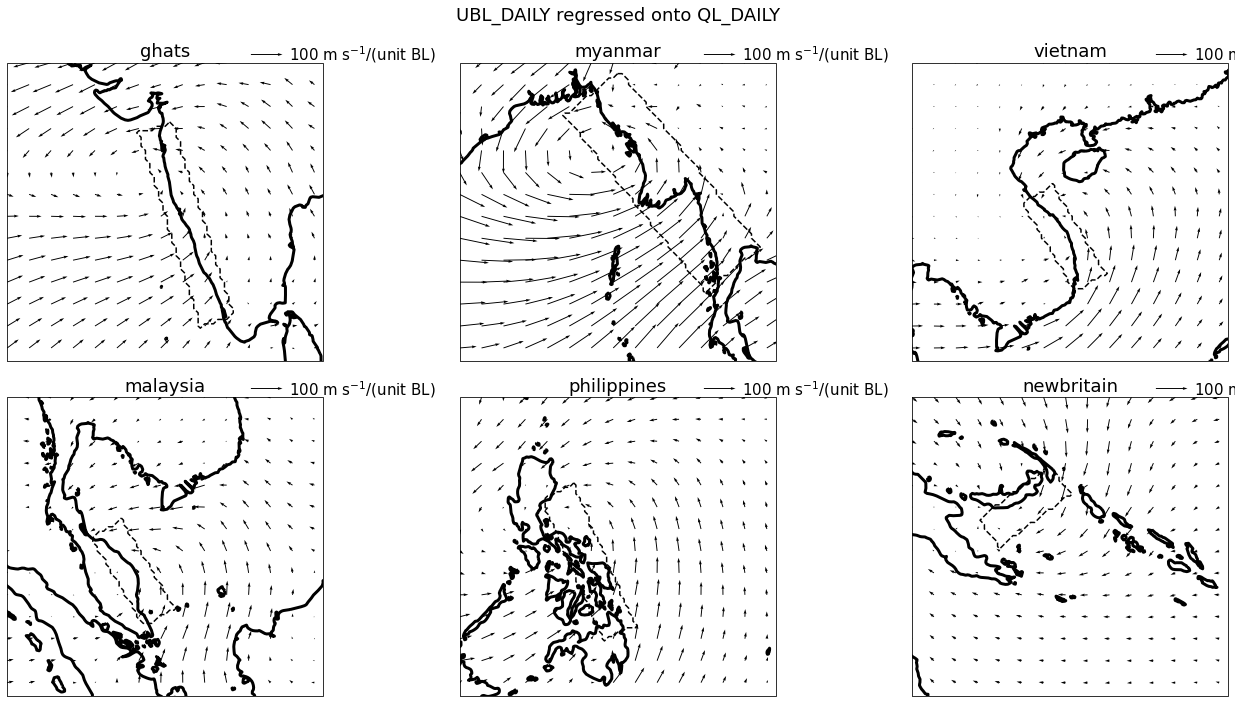

In [31]:
fig,axs = plt.subplots(2,3,figsize=(20,10),subplot_kw={"projection":ccrs.PlateCarree()})
axs=axs.reshape(-1)
predname = 'QL_DAILY'

levs = np.linspace(-60,60,21)
varname = 'UBL_DAILY'

for (ax,MR) in zip(axs,MRs):
    predqL = dBLdqL*(MR.vars['QLSEMI_ABOVE_DAILY']-MR.vars['QLSEMI_ABOVE_DAILY'].mean('time'))*2.5e6/1004. 
    predTL = dBLdTL*(MR.vars['TLSEMI_ABOVE_DAILY']-MR.vars['TLSEMI_ABOVE_DAILY'].mean('time'))
    pred = predqL
    
    u = MR.vars['UBL_DAILY'];v = MR.vars['VBL_DAILY']
    
    ureg = linregress_xr_2(pred,u)
    vreg = linregress_xr_2(pred,v)
    fdrfact = fdr_xr_2d(ureg.pvalue,0.1) + fdr_xr_2d(vreg.pvalue,0.1) >0
    #fdrfact = fdr_xr_2d(linregress_xr_2(pred,np.sqrt(u**2+v**2)).pvalue,0.1)
    u = ureg.slope /fdrfact;v=vreg.slope /fdrfact
    add_wind(ax,u,v,width=0.003,scale=1000)
    
    tilted_rect(ureg,*MR.box_tilted).plot.contour(ax=ax,levels=[0.5],linestyles=['--'],colors=['k'])
    ax.coastlines(linewidth=3)
    ax.set_title(MR.name)

fig.suptitle(varname + ' regressed onto ' + predname)
fig.tight_layout()

In [165]:
def der1(nx,dx):
    D = -np.diag(np.ones(nx-1),-1) + np.diag(np.ones(nx-1),1)
    #D[0,0] = -3; D[-1,-1] = 3
    #D[0,1] = 4 ; D[-1,-2] = -4
    #D[0,2] = -1; D[-1,-3] = 1
    return D/2/dx

def der2(nx,dx):
    return (np.diag(np.ones(nx-1),-1) - 2*np.diag(np.ones(nx),0) + np.diag(np.ones(nx-1),1))/dx**2

def transform_2d(M,nx,ny,applies_on='x'):
    if applies_on=='x':
        assert M.shape==(nx,nx)
        return np.kron(np.eye(ny,dtype=int),M)  # block diagonal matrix
    elif applies_on=='y':
        assert M.shape==(ny,ny)
        temp = np.kron(np.eye(nx,dtype=int),M)
        reindex = np.zeros(nx*ny,dtype=int)
        for j in range(ny):
            reindex[j*nx:(j+1)*nx] = j + ny*np.arange(nx)
        return temp[reindex][:,reindex]

def Mmatrix(u,v,kappa,bc='dirichlet'):
    dx = 110e3/4
    dy=dx
    ny,nx = u.shape
    Dx = der1(nx,dx)
    Dy = der1(ny,dy)
    Dx2 = der2(nx,dx)
    Dy2 = der2(ny,dy)
    U = np.diag(np.array(u).reshape(-1))
    V = np.diag(np.array(v).reshape(-1))
    M = np.dot(U,transform_2d(Dx,nx,ny,'x'))+np.dot(V,transform_2d(Dy,nx,ny,'y')) - kappa*(transform_2d(Dx2,nx,ny,'x')+transform_2d(Dy2,nx,ny,'y'))
    if bc=='dirichlet':
        M[:nx,:nx] = np.eye(nx); M[:nx,nx:]= 0.
        M[-nx:,-nx:] = np.eye(nx); M[-nx:,:-nx] = 0.
        for k in range(1,ny-1):
            M[k*nx] = 0.; M[k*nx,k*nx] = 1.
            M[k*nx + nx-1] = 0.; M[k*nx+ nx-1,k*nx+ nx-1] = 1.
    elif bc=='neumann':
        M[:nx,]= 0. ; M[:nx,:nx] = np.eye(nx)/2/dx; M[:nx,nx:2*nx] = -np.eye(nx)/2/dx
        M[-nx:] = 0.; M[-nx:,-nx:] = -np.eye(nx)/2/dx; M[-nx:,-2*nx:-nx] = np.eye(nx)/2/dx; 
        for k in range(1,ny-1):
            M[k*nx] = 0.; M[k*nx,k*nx] = -1./2/dx; M[k*nx,k*nx+1] = 1./2/dx
            M[k*nx + nx-1] = 0.; M[k*nx+ nx-1,k*nx+ nx-1] = 1./2/dx; M[k*nx+ nx-1,k*nx+ nx-2] = -1./2/dx
    
    return M
    
def solve_advdiff(u,v,kappa,upgradT,bc='dirichlet'):
    ny,nx = u.shape
    rhs = -np.array(upgradT).reshape(-1)
    rhs[:nx]=0.;rhs[-nx:]=0.;rhs[::nx] = 0.; rhs[nx-1::nx] = 0.
    M = Mmatrix(u,v,kappa,bc)
    tprime = np.linalg.solve(M,rhs)
    return (tprime.reshape(u.shape) * u**0).rename("q'")

# Regressing e_b

ghats       : 64 % variance explained
myanmar     : 27 % variance explained
vietnam     : 36 % variance explained
malaysia    : 46 % variance explained
philippines : 26 % variance explained
newbritain  : 35 % variance explained


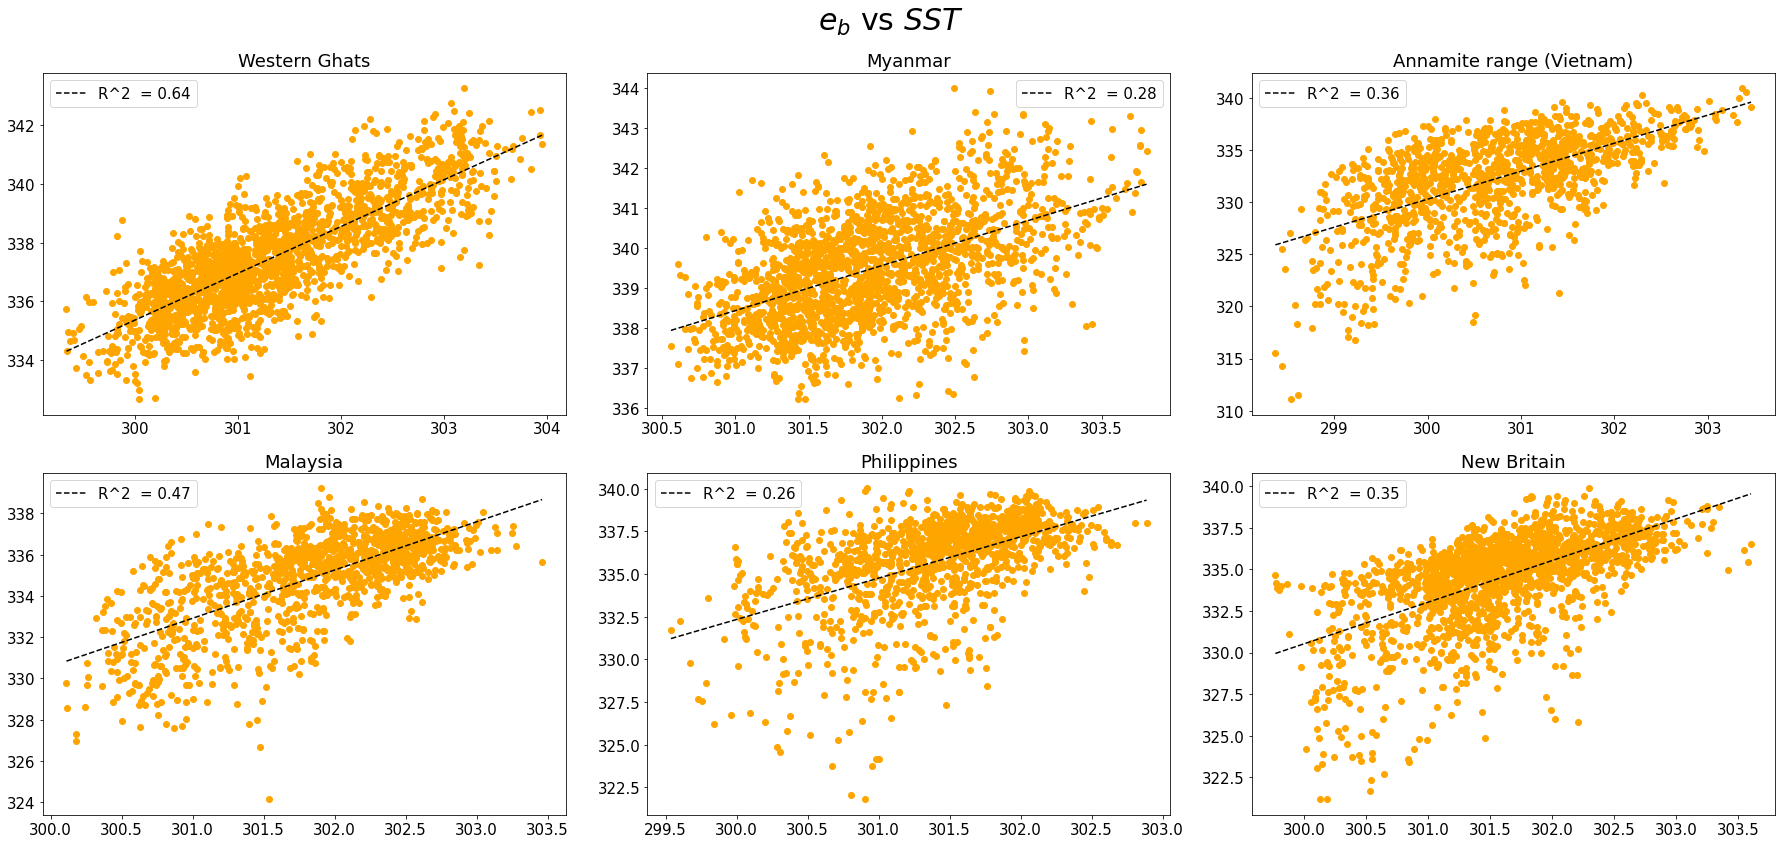

In [26]:
fig,axs = plt.subplots(2,3,figsize=(25,12))
axs=axs.reshape(-1)
for i,MR in enumerate(MRs):
    pred = MR.vars['EB_ABOVE_DAILY']

    var = MR.vars['SST_ABOVE_DAILY']

    axs[i].scatter(var,pred,color='orange')
    x,y,rsq,popt = fit_coefs(np.array(var),np.array(pred),'linear')
    axs[i].plot(x,y,color='k',linestyle='--',label='R^2  = %.2f'%rsq)
    axs[i].set_title(MR.Lname)
    axs[i].legend()
    print('{:<11s} : {:>2d} % variance explained'.format(MR.name,int(100*popt[0]**2*var.var('time')/pred.var('time'))))
    
fig.suptitle(r"$e_{b}$ vs $SST$",fontsize=30)
fig.tight_layout()

ghats       :  0 % variance explained
myanmar     :  2 % variance explained
vietnam     : 18 % variance explained
malaysia    : 14 % variance explained
philippines : 22 % variance explained
newbritain  : 17 % variance explained


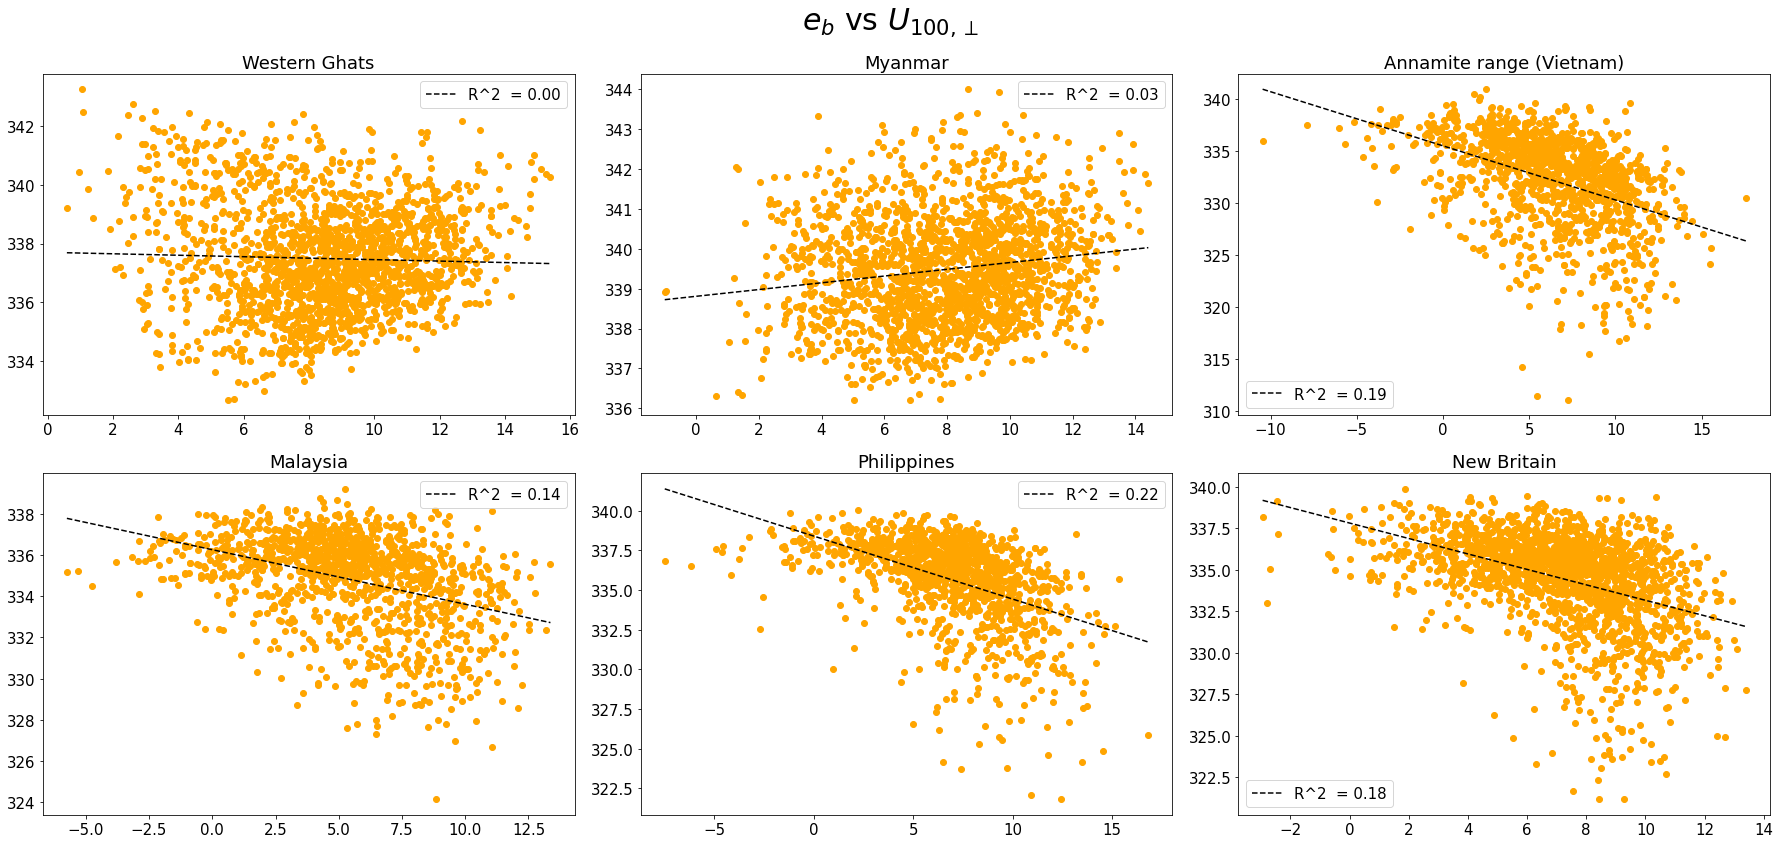

In [28]:
fig,axs = plt.subplots(2,3,figsize=(25,12))
axs=axs.reshape(-1)
for i,MR in enumerate(MRs):
    pred = MR.vars['EB_ABOVE_DAILY']

    var = MR.vars['VAR_100U_PERP_INTERVAL_DAILY']

    axs[i].scatter(var,pred,color='orange')
    x,y,rsq,popt = fit_coefs(np.array(var),np.array(pred),'linear')
    axs[i].plot(x,y,color='k',linestyle='--',label='R^2  = %.2f'%rsq)
    axs[i].set_title(MR.Lname)
    axs[i].legend()
    print('{:<11s} : {:>2d} % variance explained'.format(MR.name,int(100*popt[0]**2*var.var('time')/pred.var('time'))))
    
fig.suptitle(r"$e_{b}$ vs $U_{100,\perp}$",fontsize=30)
fig.tight_layout()

# Regressing precip

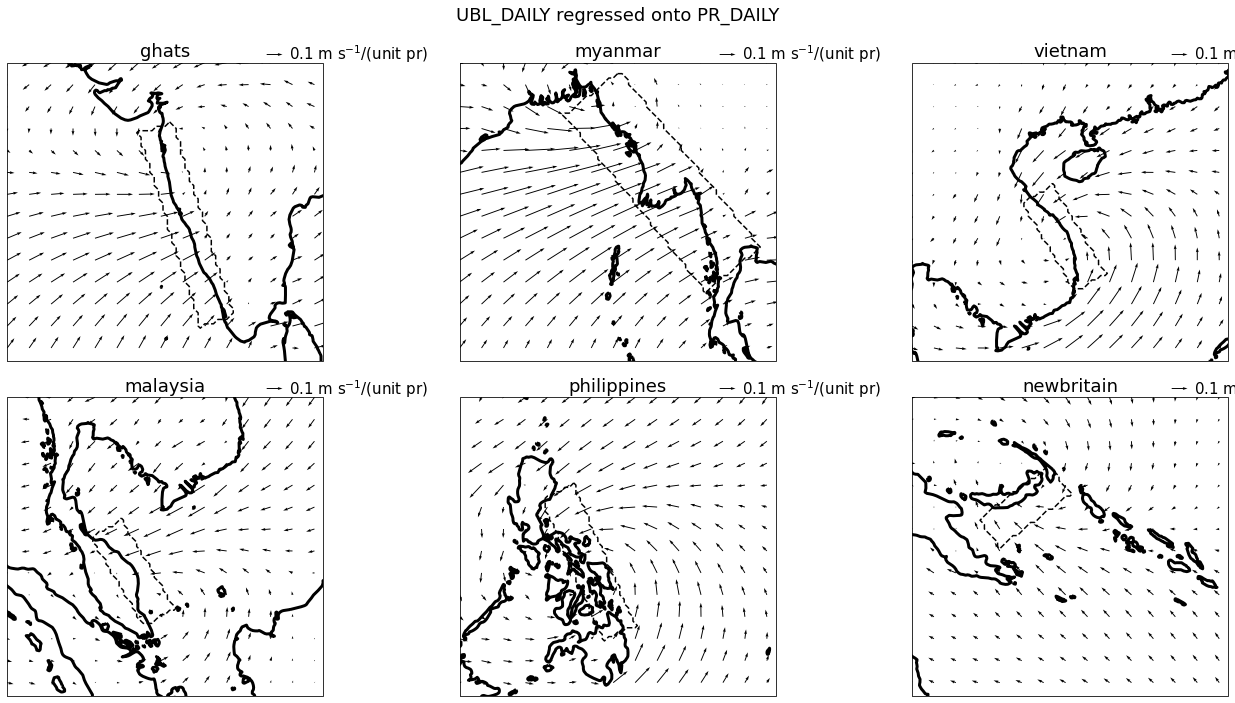

In [42]:
fig,axs = plt.subplots(2,3,figsize=(20,10),subplot_kw={"projection":ccrs.PlateCarree()})
axs=axs.reshape(-1)
predname = 'PR_DAILY'

varname = 'UBL_DAILY'

for (ax,MR) in zip(axs,MRs):
    pred = MR.vars['GPM_PR_ABOVE_DAILY']
    
    u = MR.vars['UBL_DAILY'];v = MR.vars['VBL_DAILY']
    
    ureg = linregress_xr_2(pred,u)
    vreg = linregress_xr_2(pred,v)
    fdrfact = fdr_xr_2d(ureg.pvalue,0.1) + fdr_xr_2d(vreg.pvalue,0.1) >0
    #fdrfact = fdr_xr_2d(linregress_xr_2(pred,np.sqrt(u**2+v**2)).pvalue,0.1)
    u = ureg.slope /fdrfact;v=vreg.slope /fdrfact
    add_wind(ax,u,v,width=0.003,scale=2,ref=0.1,app='/(unit pr)')
    
    tilted_rect(ureg,*MR.box_tilted).plot.contour(ax=ax,levels=[0.5],linestyles=['--'],colors=['k'])
    ax.coastlines(linewidth=3)
    ax.set_title(MR.name)

fig.suptitle(varname + ' regressed onto ' + predname)
fig.tight_layout()

# CAPE cross sections?

In [21]:
Ghats      .angle = 80 ; Ghats      .width = 0.25
Myanmar    .angle = 50 ; Myanmar    .width = 0.25
Vietnam    .angle = 240; Vietnam    .width = 0.15
Malaysia   .angle = 240; Malaysia   .width = 0.15
Philippines.angle = 250; Philippines.width = 0.25
Newbritain .angle = 310; Newbritain .width = 0.15
Cascades   .angle =  50; Cascades   .width = 0.25

In [18]:
orogm=xr.open_dataset(CMIP6_FOLDER+"ERA5/e5.oper.invariant/197901/e5.oper.invariant.128_129_z.ll025sc.1979010100_1979010100.nc").Z.isel(time=0)/9.81
gpm_pr_seasmean=xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/GPM-IMERG-seasonalmean-200101-201812.nc")
era5cape_seasmean = e5_climatology("*cape",years=range(2001,2019))

1.2561323642730713


In [19]:
for MR in MRs:
    MR.set_2dvar('CAPE',era5cape_seasmean)
    MR.set_2dvar('GPM_PR',gpm_pr_seasmean)
    MR.set_2dvar('Z',orogm)

In [17]:
def rot_slice(var,angle,width):
    rvar = rotate_var(var.transpose('latitude','longitude'),angle)
    n,m = rvar.shape
    bounds = int(m*(0.5-width)), int(m*(0.5+width))
    return rvar.isel(y=slice(*bounds)).mean('y')

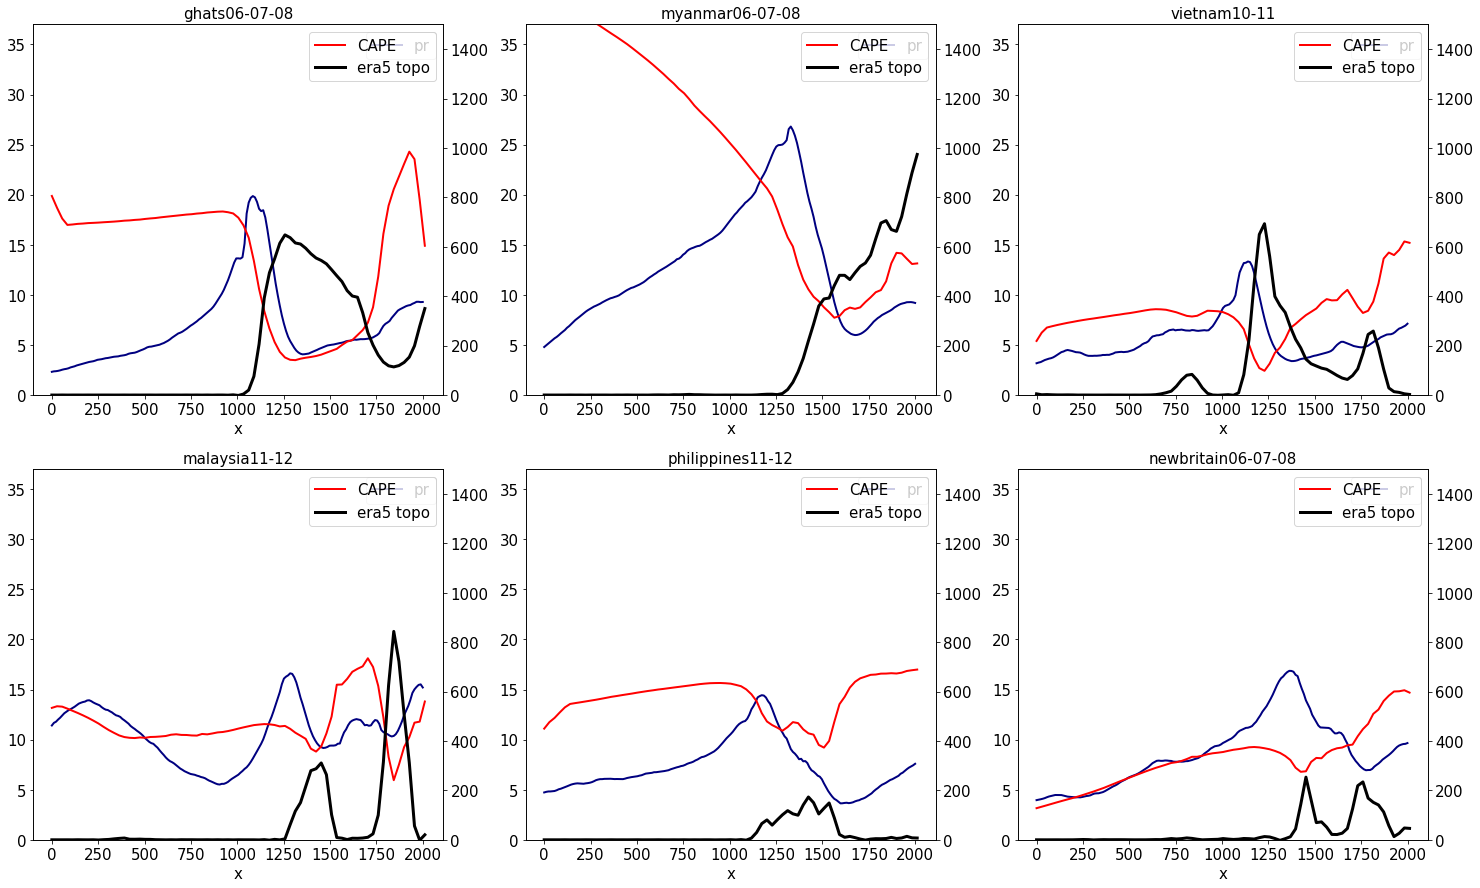

In [36]:
fig,axs = plt.subplots(2,3,figsize=(25,15))
axs=axs.reshape(-1)

for ax,MR in zip(axs,MRs):
    rot_slice(MR.vars['GPM_PR'],MR.angle,MR.width).plot(ax=ax,color='navy',linewidth=2,label='pr')

    ax2 = ax.twinx()
    rot_slice(MR.vars['CAPE'],MR.angle,MR.width).plot(ax=ax2,color='r',linewidth=2,label='CAPE')
    rot_slice(MR.vars['Z'],MR.angle,MR.width).plot(ax=ax2,color='k',linewidth=3,label='era5 topo')
    ax.legend()
    ax2.legend()
    ax.set_ylim(0,37)
    ax2.set_ylim(0,1500)
    ax.set_title(MR.name + MR._monthstr,fontsize=15)

In [28]:
for MR in MRs:
    MR.set_4dvar('Q','128_133_q') 
    MR.set_4dvar('T','128_130_t') 

In [31]:
for MR in MRs:
    es,qs,_=humidsat(MR.vars['T'],MR.vars['T'].level)
    MR.vars['ESAT']=es
    MR.vars['QSAT']=qs
    

In [48]:
for MR in MRs:
    thetae = thetae_perso(MR.vars['T'],MR.vars['Q'],MR.vars['ESAT'],MR.vars['QSAT'],pname='level')
    thetaestar = thetaestar_perso(MR.vars['T'],MR.vars['ESAT'],MR.vars['QSAT'],pname='level')
    #MR.vars['THETAEB'] = thetae.sel(level=slice(900,1100)).mean('level')
    MR.vars['THETAEB_DEEP'] = thetae.sel(level=slice(850,1100)).mean('level')
    #MR.vars['THETAELSTAR'] = thetaestar.sel(level=slice(600,899)).mean('level')
    MR.vars['THETAELSTAR_DEEP'] = thetaestar.sel(level=slice(500,849)).mean('level')

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: overflow encountered in exp
  result_data = func(*input_data)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: overflow encountered in exp
  result_data = func(*input_data)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/core/computation.py:724: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/xarray/core/com

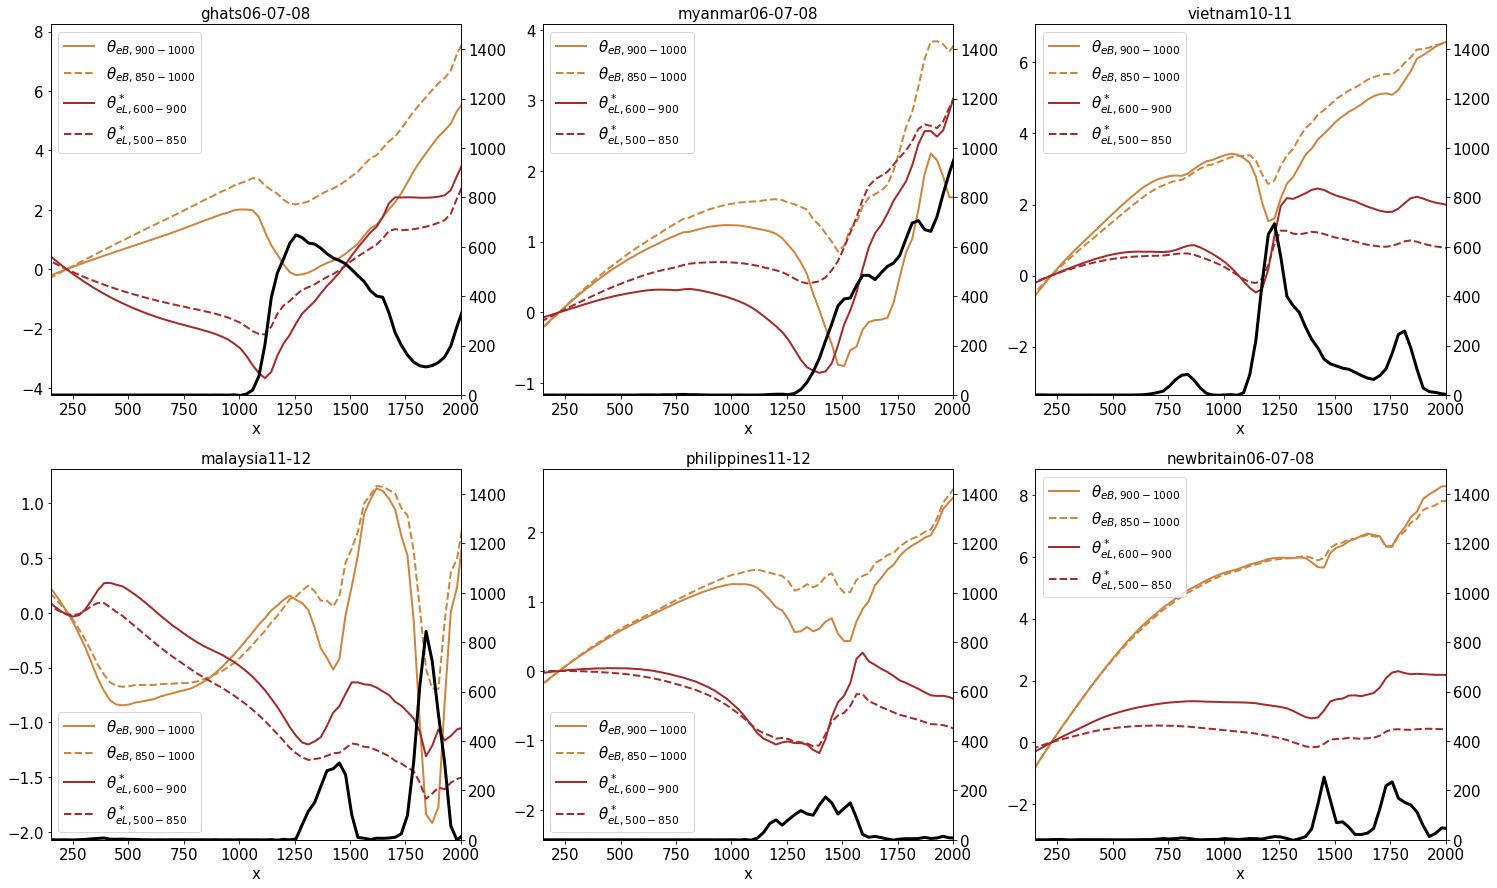

In [49]:
fig,axs = plt.subplots(2,3,figsize=(25,15))
axs=axs.reshape(-1)

for ax,MR in zip(axs,MRs):
    thetaeB = rot_slice(sel_months(MR.vars['THETAEB'],MR.months).mean('time'),MR.angle,MR.width)
    thetaeBdeep = rot_slice(sel_months(MR.vars['THETAEB_DEEP'],MR.months).mean('time'),MR.angle,MR.width)
    thetaeLstar = rot_slice(sel_months(MR.vars['THETAELSTAR'],MR.months).mean('time'),MR.angle,MR.width)
    thetaeLstardeep = rot_slice(sel_months(MR.vars['THETAELSTAR_DEEP'],MR.months).mean('time'),MR.angle,MR.width)
    
    (thetaeB-thetaeB.sel(x=slice(150,300)).mean()).plot(ax=ax,color='peru',linewidth=2,label=r'$\theta_{eB,900-1000}$')
    (thetaeBdeep-thetaeBdeep.sel(x=slice(150,300)).mean()).plot(ax=ax,color='peru',linewidth=2,linestyle='--',label=r'$\theta_{eB,850-1000}$')
    (thetaeLstar-thetaeLstar.sel(x=slice(150,300)).mean()).plot(ax=ax,color='brown',linewidth=2,label=r'$\theta_{eL,600-900}^*$')
    (thetaeLstardeep-thetaeLstardeep.sel(x=slice(150,300)).mean()).plot(ax=ax,color='brown',linewidth=2,linestyle='--',label=r'$\theta_{eL,500-850}^*$')
    
    ax2 = ax.twinx()
    rot_slice(MR.vars['Z'],MR.angle,MR.width).plot(ax=ax2,color='k',linewidth=3,label='era5 topo')
    ax2.set_ylim(0,1500)
    ax.legend()
    ax.set_title(MR.name + MR._monthstr,fontsize=15)
    ax.set_xlim(150,2000)

# QL regressions on monthly scales ?

In [51]:
era5100u_monthly=xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/e5.monthly.228_246_100u.2001-2018.nc")
era5100v_monthly=xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/e5.monthly.228_247_100v.2001-2018.nc")
gpmpr_monthly=xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/GPM-IMERG.monthly.2001-2018.nc")

for MR in MRs:
    print(MR.name)
    MR.set_othervar('VAR_100U_MONTHLY',sel_box(era5100u_monthly,MR.box))
    MR.set_othervar('VAR_100V_MONTHLY',sel_box(era5100v_monthly,MR.box))
    MR.set_othervar('GPM_PR_MONTHLY',sel_box(gpmpr_monthly,MR.box))
    
    MR.set_4dvar('T_MONTHLY',"128_130_t")
    MR.set_4dvar('Q_MONTHLY',"128_133_q")
    MR.set_4dvar('U_MONTHLY',"128_131_u")
    MR.set_4dvar('V_MONTHLY',"128_132_v")


ghats
myanmar
vietnam
malaysia
philippines
newbritain


In [112]:
for MR in MRs:
    print(MR.name)
    MR.set_4dvar('W_MONTHLY',"128_135_w")
    MR.vars['WL_MONTHLY'] = MR.vars['W_MONTHLY'].sel(level=slice(600,899)).mean('level')


ghats
myanmar
vietnam
malaysia
philippines
newbritain
Computing W_MONTHLY ...
41.77701449394226
Done ! and stored in /global/cscratch1/sd/qnicolas/regionsDataBig/


In [59]:
%%time
for MR in MRs:
    MR.vars['UBL_MONTHLY'] = MR.vars['U_MONTHLY'].sel(level=slice(900,1100)).mean('level')
    MR.vars['VBL_MONTHLY'] = MR.vars['V_MONTHLY'].sel(level=slice(900,1100)).mean('level')
    MR.vars['QLSEMI_MONTHLY'] = MR.vars['Q_MONTHLY'].sel(level=slice(600,899)).mean('level')
    grid = MR.vars['QLSEMI_MONTHLY']
    MR.vars['QLSEMI_ABOVE_MONTHLY'] = spatial_mean( MR.vars['QLSEMI_MONTHLY'],box=None,mask = tilted_rect(grid,*MR.box_tilted,reverse=False))

CPU times: user 1.3 s, sys: 274 ms, total: 1.57 s
Wall time: 1.36 s


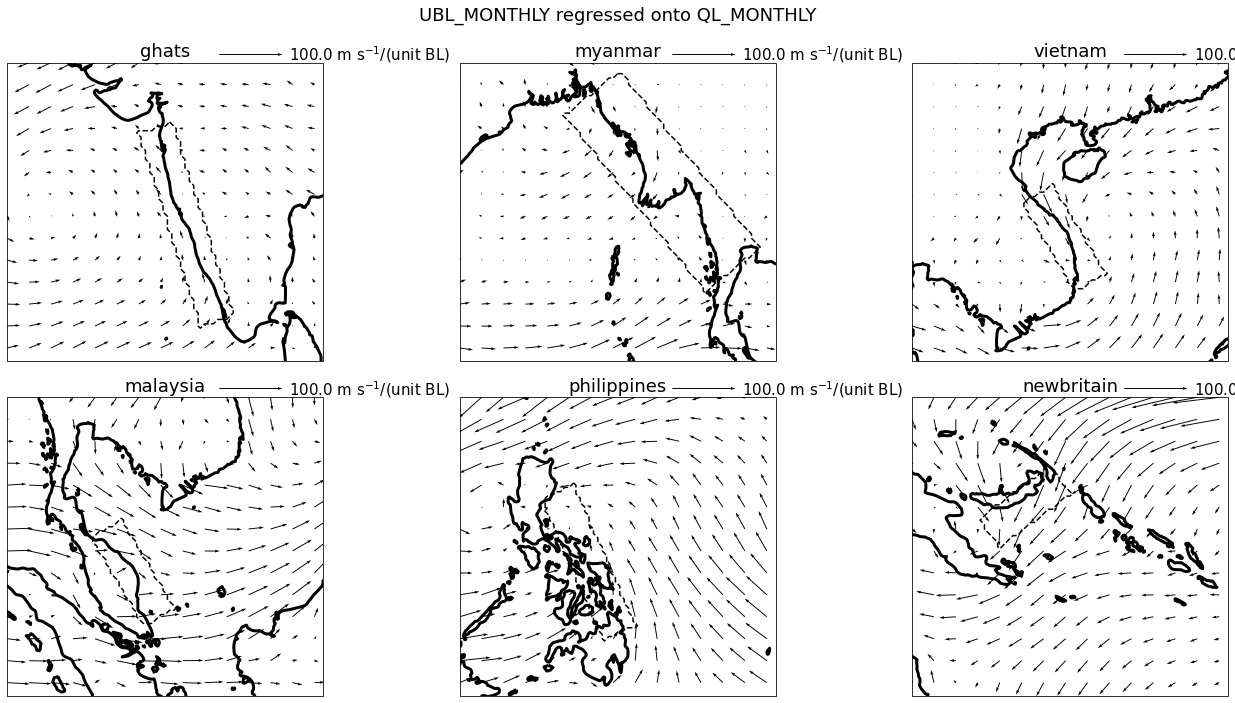

In [127]:
fig,axs = plt.subplots(2,3,figsize=(20,10),subplot_kw={"projection":ccrs.PlateCarree()})
axs=axs.reshape(-1)
predname = 'QL_MONTHLY'

levs = np.linspace(-60,60,21)
varname = 'UBL_MONTHLY'

for (ax,MR) in zip(axs,MRs):
    predqL = dBLdqL*(MR.vars['QLSEMI_ABOVE_MONTHLY']-MR.vars['QLSEMI_ABOVE_MONTHLY'].mean('time'))*2.5e6/1004. 
    pred = predqL
    
    u = MR.vars['UBL_MONTHLY'];v = MR.vars['VBL_MONTHLY']
    
    pred = pred.groupby('time.year').mean()
    u = u.groupby('time.year').mean()
    v = v.groupby('time.year').mean()
    
    ureg = linregress_xr_2(pred,u,dim='year')
    vreg = linregress_xr_2(pred,v,dim='year')
    fdrfact = 1#fdr_xr_2d(ureg.pvalue,0.1) + fdr_xr_2d(vreg.pvalue,0.1) >0
    #fdrfact = fdr_xr_2d(linregress_xr_2(pred,np.sqrt(u**2+v**2)).pvalue,0.1)
    u = ureg.slope /fdrfact;v=vreg.slope /fdrfact
    add_wind(ax,u,v,width=0.003,scale=500)
    
    tilted_rect(ureg,*MR.box_tilted).plot.contour(ax=ax,levels=[0.5],linestyles=['--'],colors=['k'])
    ax.coastlines(linewidth=3)
    ax.set_title(MR.name)

fig.suptitle(varname + ' regressed onto ' + predname)
fig.tight_layout()

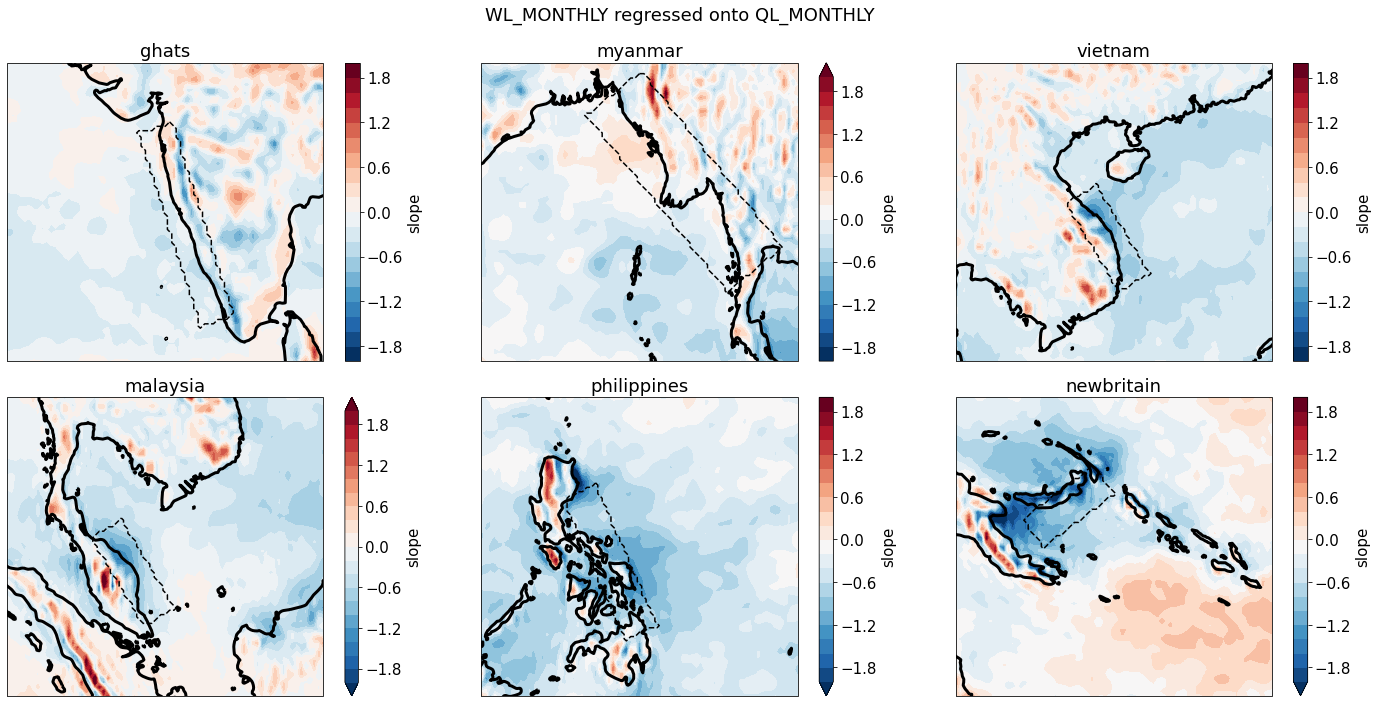

In [128]:
fig,axs = plt.subplots(2,3,figsize=(20,10),subplot_kw={"projection":ccrs.PlateCarree()})
axs=axs.reshape(-1)
predname = 'QL_MONTHLY'

levs = np.linspace(-2,2,21)
varname = 'WL_MONTHLY'

for (ax,MR) in zip(axs,MRs):
    predqL = dBLdqL*(MR.vars['QLSEMI_ABOVE_MONTHLY']-MR.vars['QLSEMI_ABOVE_MONTHLY'].mean('time'))*2.5e6/1004. 
    pred = predqL
    pred = pred.groupby('time.year').mean()
    
    reg = linregress_xr_2(pred,MR.vars['WL_MONTHLY'].groupby('time.year').mean(),dim='year')
    plot = reg.slope #* 1/(fdr_xr_2d(reg.pvalue,0.1))
    plot.plot.contourf(ax=ax,levels=levs)
    
    tilted_rect(reg,*MR.box_tilted).plot.contour(ax=ax,levels=[0.5],linestyles=['--'],colors=['k'])
    ax.coastlines(linewidth=3)
    ax.set_title(MR.name)

fig.suptitle(varname + ' regressed onto ' + predname)
fig.tight_layout()